<a href="https://colab.research.google.com/github/davidrtorres/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/blob/master/ts_model_notebook_12_10_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model 4 Time Series Notebook**

### **Introduction**
Business Problem: I am a consultant for Premium Real Estate, LLC.  The firm asked me to provide analysis and recommendations for investing in the top 5 zipcodes in Brooklyn that will provide the highest return on investment.  The investment firm is looking for short-term investments with the highest returns over a 3 year period.  The investment firm isn't looking for long term investments, ie, where a family is looking to purchase a home and stay in the home 10 to 15 years to build equity.<br>
For the task, I analyzed real estate sales data from Zillow which covers time period 4-1-1996 to 4-1-2018.<br>
I used an auto_arima model to conduct a gridsearch and find the lowest AIC scores and corresponding p,d,qs.  I used SARIMA model to make predictions regarding the test data so I get an idea of how my models were working with making predictions and then made models to perform dynamic forecasts for 3 years .<br>


In [1]:
"""
forecasting real estate prices of various zip codes using data from Zillow
Acting as a consultant for a fictional real-estate investment firm
you will be forecasting real estate prices of various zip codes 

Firm has asked you:
  What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Main task in this project is time series modeling, that isn't the overall goal 

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
print('Colab Notebook 12-9-20')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

Colab Notebook 12-9-20


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
#zillow = pd.read_csv('/content/gdrive/My Drive/data/zillow_data.csv') 
zillow = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-v2-1-onl01-dtsc-ft-070620/master/time-series/zillow_data.csv')

In [5]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

RegionID  Zipcode      City State  ...  2018-01  2018-02  2018-03  2018-04
0     84654    60657   Chicago    IL  ...  1024400  1030700  1033800  1030600
1     90668    75070  McKinney    TX  ...   318100   319600   321100   321800
2     91982    77494      Katy    TX  ...   321200   323000   326900   329900
3     84616    60614   Chicago    IL  ...  1302700  1306400  1308500  1307000
4     93144    79936   El Paso    TX  ...   120300   120500   121000   121500

[5 rows x 272 columns]

### Melted Data Function

In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [7]:
all_zipcodes = melt_data(zillow)

In [8]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [9]:
all_zipcodes.head(10)

RegionID  Zipcode           City  ... SizeRank      Month MeanValue
0     84654    60657        Chicago  ...        1 1996-04-01  334200.0
1     90668    75070       McKinney  ...        2 1996-04-01  235700.0
2     91982    77494           Katy  ...        3 1996-04-01  210400.0
3     84616    60614        Chicago  ...        4 1996-04-01  498100.0
4     93144    79936        El Paso  ...        5 1996-04-01   77300.0
5     91733    77084        Houston  ...        6 1996-04-01   95000.0
6     61807    10467       New York  ...        7 1996-04-01  152900.0
7     84640    60640        Chicago  ...        8 1996-04-01  216500.0
8     91940    77449           Katy  ...        9 1996-04-01   95400.0
9     97564    94109  San Francisco  ...       10 1996-04-01  766000.0

[10 rows x 9 columns]

In [10]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

RegionID  Zipcode      City  ... SizeRank      Month  MeanValue
10          62037    11226  New York  ...       11 1996-04-01   162000.0
13          62045    11235  New York  ...       14 1996-04-01   190500.0
47          62040    11230  New York  ...       48 1996-04-01   230100.0
49          62020    11209  New York  ...       50 1996-04-01   255700.0
53          62023    11212  New York  ...       54 1996-04-01   125000.0
...           ...      ...       ...  ...      ...        ...        ...
3887683     62035    11224  New York  ...      812 2018-04-01   517900.0
3888027     62033    11222  New York  ...     1156 2018-04-01  1721100.0
3888306     62016    11205  New York  ...     1435 2018-04-01  2248400.0
3888406     62028    11217  New York  ...     1535 2018-04-01  3656000.0
3890600     62038    11228  New York  ...     3729 2018-04-01   915300.0

[7141 rows x 9 columns]

In [11]:
test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips
    

In [12]:
test_dict

{11203: Month
 1996-04-01    149000.0
 1996-05-01    149200.0
 1996-06-01    149400.0
 1996-07-01    149600.0
 1996-08-01    149700.0
                 ...   
 2017-12-01    474500.0
 2018-01-01    475300.0
 2018-02-01    474800.0
 2018-03-01    481000.0
 2018-04-01    489900.0
 Freq: MS, Name: 11203, Length: 265, dtype: float64, 11204: Month
 1996-04-01    201100.0
 1996-05-01    201100.0
 1996-06-01    201100.0
 1996-07-01    201100.0
 1996-08-01    201100.0
                 ...   
 2017-12-01    958900.0
 2018-01-01    963200.0
 2018-02-01    967900.0
 2018-03-01    972800.0
 2018-04-01    976400.0
 Freq: MS, Name: 11204, Length: 265, dtype: float64, 11205: Month
 2004-01-01     833100.0
 2004-02-01     821400.0
 2004-03-01     812000.0
 2004-04-01     805500.0
 2004-05-01     801400.0
                 ...    
 2017-12-01    2251000.0
 2018-01-01    2251600.0
 2018-02-01    2245300.0
 2018-03-01    2243700.0
 2018-04-01    2248400.0
 Freq: MS, Name: 11205, Length: 172, dtype: float64

In [13]:
zip_df = pd.concat(test_dict, axis=1)

In [14]:
len(zip_df)

265

### **Dataframe of Brooklyn Zipcodes** 

In [15]:
zip_df.head()

11226     11235     11230  ...  11238  11205  11217
Month                                     ...                     
1996-04-01  162000.0  190500.0  230100.0  ...    NaN    NaN    NaN
1996-05-01  162300.0  191000.0  230800.0  ...    NaN    NaN    NaN
1996-06-01  162600.0  191500.0  231500.0  ...    NaN    NaN    NaN
1996-07-01  163000.0  192000.0  232100.0  ...    NaN    NaN    NaN
1996-08-01  163400.0  192500.0  232800.0  ...    NaN    NaN    NaN

[5 rows x 28 columns]

In [16]:
zip_df.tail()

11226     11235      11230  ...      11238      11205      11217
Month                                      ...                                 
2017-12-01  887800.0  799700.0  1102400.0  ...  2768900.0  2251000.0  3404100.0
2018-01-01  890500.0  806600.0  1120200.0  ...  2810700.0  2251600.0  3413800.0
2018-02-01  901700.0  810600.0  1141600.0  ...  2848100.0  2245300.0  3482900.0
2018-03-01  930700.0  813400.0  1170000.0  ...  2869600.0  2243700.0  3588100.0
2018-04-01  963200.0  816200.0  1195400.0  ...  2885300.0  2248400.0  3656000.0

[5 rows x 28 columns]

In [17]:
len(zip_df.columns)

28

In [18]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [19]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

In [20]:
zip_df.bfill(inplace=True)

In [21]:
zip_df.isna().sum()

11226    0
11235    0
11230    0
11209    0
11212    0
11214    0
11221    0
11229    0
11234    0
11215    0
11211    0
11233    0
11236    0
11218    0
11223    0
11208    0
11204    0
11219    0
11203    0
11220    0
11216    0
11210    0
11224    0
11222    0
11228    0
11238    0
11205    0
11217    0
dtype: int64

In [22]:
zip_df[11238].value_counts(dropna=False)

671200.0     94
1177800.0     2
1839100.0     1
1033400.0     1
2530000.0     1
             ..
2346900.0     1
665400.0      1
1237600.0     1
1361500.0     1
1638400.0     1
Name: 11238, Length: 171, dtype: int64

In [23]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

In [24]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

### **Visual of Price Trends of Brooklyn Zipcodes**

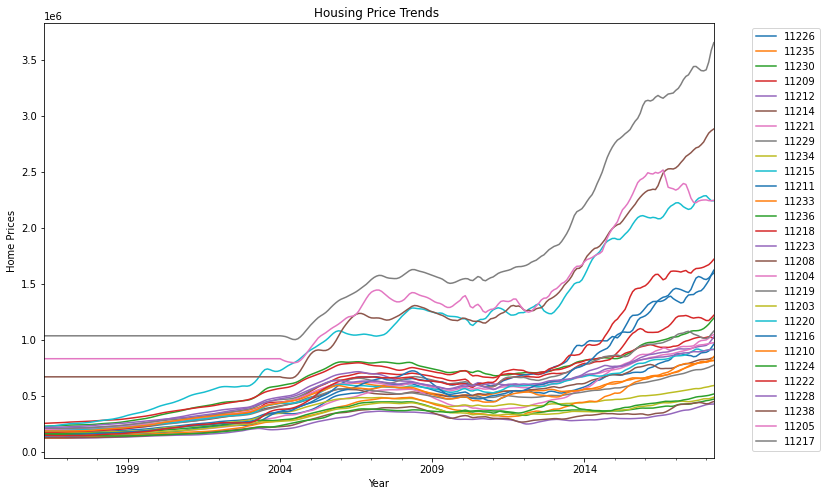

In [25]:
"""
11217(gray) - over 3.5
11238(brown) - 3.0 
11205        - 2.25
11215(acqua) - 2.25
11222(red)   - 1.7

2007–08 Housing Market Crash
"""
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Prices')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

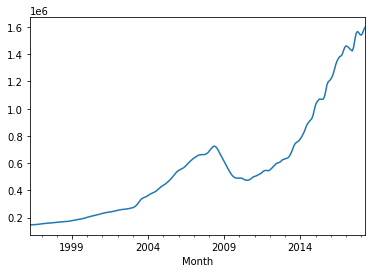

In [26]:
zip_df[11216].plot()

### **Train/Test Split**

In [27]:
"""
 train data set is from 1996–04–01 to 2014–01–01. The length of our test data we get 214 rows, or 214 time periods. 
 
 test data set is from 2014–01–01 to 2018–04–01. The length of our test data we get 52 rows, or 52 time periods. 
 That is the value will use for our .predict() method 

"""
year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [28]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(214, 28)
(52, 28)


In [29]:
train_brk.tail()

11226     11235     11230  ...      11238      11205      11217
Month                                     ...                                 
2013-09-01  551600.0  545200.0  791000.0  ...  1613500.0  1640100.0  2111700.0
2013-10-01  558900.0  547300.0  802300.0  ...  1638400.0  1658800.0  2146000.0
2013-11-01  566200.0  550600.0  809000.0  ...  1640700.0  1659500.0  2158600.0
2013-12-01  572600.0  554600.0  813000.0  ...  1661500.0  1670200.0  2173100.0
2014-01-01  580700.0  558200.0  819000.0  ...  1709200.0  1700200.0  2202400.0

[5 rows x 28 columns]

In [30]:
test_brk.head()

11226     11235     11230  ...      11238      11205      11217
Month                                     ...                                 
2014-01-01  580700.0  558200.0  819000.0  ...  1709200.0  1700200.0  2202400.0
2014-02-01  590500.0  560000.0  822500.0  ...  1748800.0  1718500.0  2238400.0
2014-03-01  602600.0  562300.0  823200.0  ...  1773300.0  1727000.0  2271000.0
2014-04-01  618300.0  566300.0  824000.0  ...  1798700.0  1736700.0  2298000.0
2014-05-01  632300.0  572000.0  827900.0  ...  1818100.0  1752000.0  2342400.0

[5 rows x 28 columns]

## **Auto_Arima Model**

In [31]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [32]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 12.9MB/s 
     |████████████████████████████████| 2.1MB 45.0MB/s 
     |████████████████████████████████| 9.5MB 49.4MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [33]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [34]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)
"""
auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model.
ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: 
  seasonality, trend, and noise. These parameters are labeled p,d,and q.


p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. 
  For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

d is the parameter associated with the integrated part of the model, which effects the amount of 
  differencing to apply to a time series. ie, forecasting that the amount of rain tomorrow will be similar 
  to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

q is the parameter associated with the moving average part of the model.

P,D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components 
  of the model.
"""
def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 0, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=0, D=1, trace = True, #start 0
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    return autoarima_model


In [35]:
stepwise_fit = arima_model(train_brk[11226])

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4116.531, Time=1.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4186.338, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4111.966, Time=1.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4211.321, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4147.894, Time=1.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4104.096, Time=1.25 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=4132.912, Time=1.97 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4162.447, Time=0.27 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4158.454, Time=0.64 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4092.751, Time=3.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4127.548, Time=0.74 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.33 sec
 ARIMA(1,1,1)(0,1,2)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2038.094
Date:                            Thu, 10 Dec 2020   AIC                           4086.188
Time:                                    13:09:29   BIC                           4102.705
Sample:                                         0   HQIC                          4092.871
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

In [36]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2038.094
Date:                            Thu, 10 Dec 2020   AIC                           4086.188
Time:                                    13:09:29   BIC                           4102.705
Sample:                                         0   HQIC                          4092.871
                                            - 214                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7137      0.058     12.407      0.000       0.601       0.826
ma.L1         -0.4503      0.059     -7.686      0.000      -0.565      -0.335
ma.S.L12      -0.3650      0.023    -15.883      0.000      -0.410      -0.320
ma.S.L24      -0.1213      0.014     -8.872      0.000      -0.148      -0.095
sigma2      3.688e+07   1.65e-10   2.23e+17      0.000    3.69e+07    3.69e+07
===================================================================================
Ljung-Box (Q):                      181.53   Jarque-Bera (JB):               133.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             0.34
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.85e+32. Standard errors may be unstable.
"""

### **Statsmodel Summary of Brooklyn Zipcodes**

In [37]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in zip_df.columns:
  zip_test_2 = arima_model(zip_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5217.526, Time=1.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5324.110, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5210.861, Time=1.58 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5292.651, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5215.212, Time=2.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5194.092, Time=1.15 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5208.395, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5195.883, Time=4.78 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5195.906, Time=4.41 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5198.366, Time=2.45 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=7.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.90 sec
 ARIMA(0,1,1)(1,1,1)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2593.046
Date:                            Thu, 10 Dec 2020   AIC                           5194.092
Time:                                    13:10:10   BIC                           5208.210
Sample:                                         0   HQIC                          5199.773
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3688      0.010     37.281      0.000       0.349       0.388
ar.S.L12       0.3880      0.022     17.778      0.000       0.345       0.431
ma.S.L12      -0.8531      0.031    -27.796      0.000      -0.913      -0.793
sigma2      3.679e+07   1.93e-10   1.91e+17      0.000    3.68e+07    3.68e+07
===================================================================================
Ljung-Box (Q):                      155.59   Jarque-Bera (JB):               235.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.73
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4905.170, Time=1.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4924.283, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4903.177, Time=1.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4904.292, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5009.782, Time=2.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=4902.792, Time=1.72 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5005.263, Time=2.35 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.82 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4926.793, Time=0.38 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=4899.299, Time=2.20 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=4901.239, Time=0.75 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=4894.359, Time=6.24 sec
 ARIMA(2,1,0)(1,1,2)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2436.931
Date:                            Thu, 10 Dec 2020   AIC                           4885.863
Time:                                    13:13:08   BIC                           4907.039
Sample:                                         0   HQIC                          4894.384
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0412      0.035     30.015      0.000       0.973       1.109
ar.L2         -0.0720      0.015     -4.930      0.000      -0.101      -0.043
ma.L1         -0.9094      0.027    -33.969      0.000      -0.962      -0.857
ma.S.L12      -0.1413      0.016     -8.942      0.000      -0.172      -0.110
ma.S.L24      -0.0753      0.008     -8.924      0.000      -0.092      -0.059
sigma2      1.436e+07   6.39e-10   2.25e+16      0.000    1.44e+07    1.44e+07
===================================================================================
Ljung-Box (Q):                      218.74   Jarque-Bera (JB):                23.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.40   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.8e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5153.726, Time=0.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5184.121, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5328.856, Time=0.86 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5173.771, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5148.405, Time=2.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.03 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5180.157, Time=1.54 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5141.813, Time=8.97 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5119.264, Time=4.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5132.429, Time=1.39 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.25 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5120.238, Time=2.68 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=11.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2550.400
Date:                            Thu, 10 Dec 2020   AIC                           5112.801
Time:                                    13:15:46   BIC                           5133.977
Sample:                                         0   HQIC                          5121.322
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    391.9607    174.373      2.248      0.025      50.196     733.725
ar.L1          0.6400      0.057     11.154      0.000       0.528       0.752
ma.L1         -0.4475      0.058     -7.736      0.000      -0.561      -0.334
ma.S.L12      -0.1871      0.017    -10.852      0.000      -0.221      -0.153
ma.S.L24      -0.0727      0.011     -6.496      0.000      -0.095      -0.051
sigma2      3.511e+07      0.001   2.98e+10      0.000    3.51e+07    3.51e+07
===================================================================================
Ljung-Box (Q):                      296.81   Jarque-Bera (JB):               181.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.79
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.11e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5207.433, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5190.872, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5251.555, Time=0.79 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5187.411, Time=0.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5179.811, Time=0.90 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5235.500, Time=2.14 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5198.229, Time=1.24 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5321.173, Time=2.56 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5180.119, Time=1.11 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 14.153 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2586.905
Date:                            Thu, 10 Dec 2020   AIC                           5179.811
Time:                                    13:16:00   BIC                           5190.399
Sample:                                         0   HQIC                          5184.071
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1455      0.013    -11.042      0.000      -0.171      -0.120
ar.S.L24      -0.0754      0.010     -7.620      0.000      -0.095      -0.056
sigma2      4.174e+07   5.44e-12   7.67e+18      0.000    4.17e+07    4.17e+07
===================================================================================
Ljung-Box (Q):                      391.16   Jarque-Bera (JB):                38.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+35. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4807.386, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4862.510, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4795.191, Time=1.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4810.643, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4794.595, Time=6.04 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4851.329, Time=0.99 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4773.837, Time=7.81 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4775.437, Time=2.88 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.94 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.42 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4769.377, Time=8.23 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4771.375, Time=3.18 sec
 ARIMA(3,1,0)(2,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2378.688
Date:                            Thu, 10 Dec 2020   AIC                           4769.377
Time:                                    13:17:45   BIC                           4790.553
Sample:                                         0   HQIC                          4777.898
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1981      0.006     35.869      0.000       0.187       0.209
ar.L2          0.1238      0.008     15.631      0.000       0.108       0.139
ar.L3          0.0715      0.013      5.478      0.000       0.046       0.097
ar.S.L12      -0.1488      0.015     -9.887      0.000      -0.178      -0.119
ar.S.L24      -0.0515      0.015     -3.323      0.001      -0.082      -0.021
sigma2       8.59e+06   6.13e-11    1.4e+17      0.000    8.59e+06    8.59e+06
===================================================================================
Ljung-Box (Q):                      455.85   Jarque-Bera (JB):               372.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.87
Prob(H) (two-sided):                  0.64   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5058.465, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5065.172, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5014.850, Time=1.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5029.881, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5007.198, Time=5.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.01 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5053.780, Time=1.09 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5000.580, Time=7.55 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5008.061, Time=2.62 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.09 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.40 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5001.116, Time=7.92 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5467.083, Time=11.57 sec
 ARIMA(1,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2494.154
Date:                            Thu, 10 Dec 2020   AIC                           4998.307
Time:                                    13:19:51   BIC                           5015.954
Sample:                                         0   HQIC                          5005.408
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6192      0.064      9.605      0.000       0.493       0.746
ma.L1         -0.4546      0.065     -6.956      0.000      -0.583      -0.326
ar.S.L12      -0.1714      0.012    -14.868      0.000      -0.194      -0.149
ar.S.L24      -0.0761      0.010     -7.781      0.000      -0.095      -0.057
sigma2       2.26e+07   4.11e-10    5.5e+16      0.000    2.26e+07    2.26e+07
===================================================================================
Ljung-Box (Q):                      250.08   Jarque-Bera (JB):               213.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5064.512, Time=1.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5129.825, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5091.808, Time=0.59 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5077.876, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.86 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5094.781, Time=1.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5067.112, Time=1.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=9.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5126.260, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5036.746, Time=3.95 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5063.806, Time=0.79 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5032.336, Time=9.05 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=10.66 sec
 ARIMA(1,1,0)(0,1,2)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 2, 12)   Log Likelihood               -2511.168
Date:                            Thu, 10 Dec 2020   AIC                           5032.336
Time:                                    13:21:37   BIC                           5049.984
Sample:                                         0   HQIC                          5039.437
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7343      0.049     14.878      0.000       0.638       0.831
ma.L1         -0.4285      0.049     -8.692      0.000      -0.525      -0.332
ma.S.L12      -0.3498      0.022    -15.612      0.000      -0.394      -0.306
ma.S.L24      -0.1113      0.015     -7.636      0.000      -0.140      -0.083
sigma2      2.665e+07   4.64e-10   5.75e+16      0.000    2.66e+07    2.66e+07
===================================================================================
Ljung-Box (Q):                      177.11   Jarque-Bera (JB):               369.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4882.985, Time=0.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4847.422, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4826.980, Time=1.95 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4828.335, Time=0.26 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4824.801, Time=5.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.68 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4844.675, Time=0.93 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4820.058, Time=7.51 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4822.417, Time=2.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4820.188, Time=8.25 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=11.42 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.029
Date:                            Thu, 10 Dec 2020   AIC                           4820.058
Time:                                    13:23:09   BIC                           4837.705
Sample:                                         0   HQIC                          4827.158
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0976      0.005     18.551      0.000       0.087       0.108
ar.L2          0.0553      0.009      6.136      0.000       0.038       0.073
ar.S.L12      -0.0740      0.017     -4.344      0.000      -0.107      -0.041
ar.S.L24      -0.0412      0.012     -3.482      0.000      -0.064      -0.018
sigma2      1.108e+07    3.5e-11   3.17e+17      0.000    1.11e+07    1.11e+07
===================================================================================
Ljung-Box (Q):                      276.43   Jarque-Bera (JB):                25.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.10
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4766.470, Time=1.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4782.322, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4765.197, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4766.673, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4762.711, Time=4.93 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.91 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4778.975, Time=0.91 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4759.883, Time=7.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4762.518, Time=2.63 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4760.680, Time=7.61 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=4917.421, Time=12.04 sec
 ARIMA(1,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2374.942
Date:                            Thu, 10 Dec 2020   AIC                           4759.883
Time:                                    13:24:45   BIC                           4777.531
Sample:                                         0   HQIC                          4766.984
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0872      0.005     16.396      0.000       0.077       0.098
ar.L2          0.0456      0.010      4.621      0.000       0.026       0.065
ar.S.L12      -0.0730      0.016     -4.610      0.000      -0.104      -0.042
ar.S.L24      -0.0418      0.011     -3.798      0.000      -0.063      -0.020
sigma2       8.71e+06   5.87e-11   1.48e+17      0.000    8.71e+06    8.71e+06
===================================================================================
Ljung-Box (Q):                      299.47   Jarque-Bera (JB):                37.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.60
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.64e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5505.900, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5632.039, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5496.697, Time=0.58 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5552.635, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5471.450, Time=1.84 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5454.971, Time=4.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5453.002, Time=1.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5470.804, Time=0.66 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=5454.966, Time=4.29 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=4.82 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=5.78 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.57 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2722.501
Date:                            Thu, 10 Dec 2020   AIC                           5453.002
Time:                                    13:25:25   BIC                           5467.120
Sample:                                         0   HQIC                          5458.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5138      0.012     43.530      0.000       0.491       0.537
ar.S.L12       0.4223      0.026     16.172      0.000       0.371       0.473
ma.S.L12      -0.8844      0.036    -24.783      0.000      -0.954      -0.814
sigma2      1.003e+08   2.31e-11   4.34e+18      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (Q):                       98.22   Jarque-Bera (JB):               545.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5360.031, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5576.658, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5356.960, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5443.137, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5338.715, Time=1.61 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5332.823, Time=3.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5330.853, Time=0.79 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5328.885, Time=0.58 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5330.852, Time=1.48 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5486.420, Time=0.29 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5325.499, Time=0.78 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=5467.759, Time=0.28 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=5327.390, Time=1.17 sec
 ARIMA(2,1,0)(0,1,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2657.505
Date:                            Thu, 10 Dec 2020   AIC                           5325.010
Time:                                    13:26:35   BIC                           5342.657
Sample:                                         0   HQIC                          5332.111
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    320.5835    209.151      1.533      0.125     -89.345     730.512
ar.L1          0.5356      0.064      8.312      0.000       0.409       0.662
ma.L1          0.0557      0.064      0.874      0.382      -0.069       0.181
ma.S.L12      -0.7134      0.036    -19.942      0.000      -0.784      -0.643
sigma2      7.996e+07      0.001    7.4e+10      0.000       8e+07       8e+07
===================================================================================
Ljung-Box (Q):                       98.50   Jarque-Bera (JB):               267.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.62e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5077.160, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5067.625, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5030.213, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5047.671, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5010.732, Time=4.35 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5063.174, Time=1.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5062.240, Time=1.76 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5087.348, Time=3.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5017.695, Time=3.89 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5090.209, Time=2.24 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=5011.723, Time=4.90 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 33.364 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2501.366
Date:                            Thu, 10 Dec 2020   AIC                           5010.732
Time:                                    13:27:08   BIC                           5024.850
Sample:                                         0   HQIC                          5016.413
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.010     29.946      0.000       0.281       0.321
ar.S.L12      -0.1976      0.022     -8.850      0.000      -0.241      -0.154
ar.S.L24      -0.0793      0.021     -3.724      0.000      -0.121      -0.038
sigma2      2.401e+07   1.08e-10   2.21e+17      0.000     2.4e+07     2.4e+07
===================================================================================
Ljung-Box (Q):                      162.04   Jarque-Bera (JB):               541.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.03   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.42e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4862.141, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4878.002, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4841.924, Time=1.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4848.529, Time=0.32 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4838.425, Time=5.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.03 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4870.436, Time=0.82 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4826.653, Time=8.27 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4830.428, Time=2.85 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.42 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.63 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4822.351, Time=8.43 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4826.361, Time=3.32 sec
 ARIMA(3,1,0)(2,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2405.175
Date:                            Thu, 10 Dec 2020   AIC                           4822.351
Time:                                    13:28:57   BIC                           4843.528
Sample:                                         0   HQIC                          4830.872
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1317      0.005     24.895      0.000       0.121       0.142
ar.L2          0.0839      0.008     10.419      0.000       0.068       0.100
ar.L3          0.0608      0.010      5.792      0.000       0.040       0.081
ar.S.L12      -0.1137      0.013     -8.859      0.000      -0.139      -0.089
ar.S.L24      -0.0542      0.011     -4.999      0.000      -0.076      -0.033
sigma2       1.09e+07   2.79e-11   3.91e+17      0.000    1.09e+07    1.09e+07
===================================================================================
Ljung-Box (Q):                      364.26   Jarque-Bera (JB):                94.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.77
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.31e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5298.188, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5442.108, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5316.986, Time=0.80 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5377.311, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5286.925, Time=1.20 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5324.662, Time=0.40 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5288.925, Time=3.02 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5288.925, Time=4.31 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5288.877, Time=2.56 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5305.187, Time=1.13 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5290.924, Time=3.48 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=3.92 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.40 sec
 ARIMA(1,1,0)(1,1,1)[12]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2632.706
Date:                            Thu, 10 Dec 2020   AIC                           5273.411
Time:                                    13:29:56   BIC                           5287.529
Sample:                                         0   HQIC                          5279.092
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4631      0.009     54.365      0.000       0.446       0.480
ar.S.L12       0.3205      0.019     17.182      0.000       0.284       0.357
ma.S.L12      -0.8026      0.030    -27.096      0.000      -0.861      -0.745
sigma2       4.34e+07   1.73e-10   2.51e+17      0.000    4.34e+07    4.34e+07
===================================================================================
Ljung-Box (Q):                      191.19   Jarque-Bera (JB):               774.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.73
Prob(H) (two-sided):                  0.54   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5103.547, Time=1.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5138.306, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5099.422, Time=1.75 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5105.227, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5094.185, Time=5.23 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.19 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5130.736, Time=0.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5089.127, Time=7.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5094.955, Time=2.80 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.37 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5089.343, Time=8.08 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5457.581, Time=12.79 sec
 ARIMA(1,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2539.563
Date:                            Thu, 10 Dec 2020   AIC                           5089.127
Time:                                    13:31:33   BIC                           5106.774
Sample:                                         0   HQIC                          5096.228
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1810      0.007     27.172      0.000       0.168       0.194
ar.L2          0.0795      0.013      5.937      0.000       0.053       0.106
ar.S.L12      -0.1438      0.016     -9.119      0.000      -0.175      -0.113
ar.S.L24      -0.0734      0.012     -5.983      0.000      -0.097      -0.049
sigma2      3.267e+07   1.34e-11   2.43e+18      0.000    3.27e+07    3.27e+07
===================================================================================
Ljung-Box (Q):                      219.95   Jarque-Bera (JB):               348.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.36e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4951.003, Time=1.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5027.532, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4939.756, Time=1.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4958.915, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4925.407, Time=5.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4998.015, Time=0.93 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4913.691, Time=8.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4928.488, Time=3.32 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.95 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.28 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4914.827, Time=7.47 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=4929.182, Time=10.72 sec
 ARIMA(1,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2451.845
Date:                            Thu, 10 Dec 2020   AIC                           4913.691
Time:                                    13:33:11   BIC                           4931.338
Sample:                                         0   HQIC                          4920.792
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2831      0.007     39.195      0.000       0.269       0.297
ar.L2          0.1285      0.013      9.565      0.000       0.102       0.155
ar.S.L12      -0.2366      0.012    -19.284      0.000      -0.261      -0.213
ar.S.L24      -0.1233      0.010    -12.614      0.000      -0.143      -0.104
sigma2      1.585e+07   7.33e-11   2.16e+17      0.000    1.59e+07    1.59e+07
===================================================================================
Ljung-Box (Q):                      175.38   Jarque-Bera (JB):               623.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.84
Prob(H) (two-sided):                  0.35   Kurtosis:                        10.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.84e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4987.651, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4973.768, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4943.409, Time=1.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4950.233, Time=0.28 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4939.514, Time=5.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4966.205, Time=0.92 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4933.348, Time=7.74 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4937.526, Time=3.40 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.61 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.62 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4932.885, Time=8.59 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=4937.261, Time=3.05 sec
 ARIMA(3,1,0)(2,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2460.443
Date:                            Thu, 10 Dec 2020   AIC                           4932.885
Time:                                    13:35:00   BIC                           4954.062
Sample:                                         0   HQIC                          4941.407
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1163      0.006     21.024      0.000       0.105       0.127
ar.L2          0.0636      0.010      6.668      0.000       0.045       0.082
ar.L3          0.0367      0.015      2.390      0.017       0.007       0.067
ar.S.L12      -0.1136      0.013     -9.045      0.000      -0.138      -0.089
ar.S.L24      -0.0539      0.010     -5.340      0.000      -0.074      -0.034
sigma2      1.726e+07   2.19e-11    7.9e+17      0.000    1.73e+07    1.73e+07
===================================================================================
Ljung-Box (Q):                      337.70   Jarque-Bera (JB):                31.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.41
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5266.294, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5307.778, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5230.085, Time=1.84 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5249.734, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.999, Time=1.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5222.048, Time=1.64 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5209.512, Time=4.95 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.67 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=5262.204, Time=3.23 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=5203.031, Time=6.31 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5215.319, Time=2.71 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=inf, Time=9.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(3,1,0)(0,1,2)[12]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(0, 1, 2, 12)   Log Likelihood               -2596.515
Date:                            Thu, 10 Dec 2020   AIC                           5203.031
Time:                                    13:36:37   BIC                           5220.678
Sample:                                         0   HQIC                          5210.132
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.009     29.382      0.000       0.251       0.287
ar.L2          0.1047      0.019      5.509      0.000       0.067       0.142
ma.S.L12      -0.3357      0.021    -16.248      0.000      -0.376      -0.295
ma.S.L24      -0.1465      0.012    -11.944      0.000      -0.171      -0.122
sigma2      5.141e+07   3.21e-11    1.6e+18      0.000    5.14e+07    5.14e+07
===================================================================================
Ljung-Box (Q):                      161.48   Jarque-Bera (JB):               401.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.60
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4811.280, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4798.502, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4773.764, Time=1.63 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4775.721, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4771.602, Time=4.60 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4795.656, Time=1.67 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4766.701, Time=7.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4769.087, Time=2.56 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=11.27 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.85 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4766.633, Time=7.76 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=5297.235, Time=0.92 sec
 ARIMA(3,1,0)(2,1,1)[12]             :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2377.316
Date:                            Thu, 10 Dec 2020   AIC                           4766.633
Time:                                    13:38:15   BIC                           4787.809
Sample:                                         0   HQIC                          4775.154
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1185      0.006     21.124      0.000       0.107       0.129
ar.L2          0.0592      0.010      5.686      0.000       0.039       0.080
ar.L3          0.0344      0.017      2.038      0.042       0.001       0.067
ar.S.L12      -0.0884      0.016     -5.412      0.000      -0.120      -0.056
ar.S.L24      -0.0474      0.012     -3.816      0.000      -0.072      -0.023
sigma2      8.802e+06   5.69e-11   1.55e+17      0.000     8.8e+06     8.8e+06
===================================================================================
Ljung-Box (Q):                      244.65   Jarque-Bera (JB):                45.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.37e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5142.891, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5192.097, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5112.446, Time=1.79 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5141.183, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5106.730, Time=4.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5091.082, Time=3.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5105.256, Time=1.56 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=8.34 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5166.462, Time=2.35 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=10.18 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.88 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.22 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -2541.541
Date:                            Thu, 10 Dec 2020   AIC                           5091.082
Time:                                    13:39:17   BIC                           5105.200
Sample:                                         0   HQIC                          5096.763
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2365      0.009     27.622      0.000       0.220       0.253
ar.S.L12       0.4904      0.028     17.294      0.000       0.435       0.546
ma.S.L12      -0.8364      0.042    -19.903      0.000      -0.919      -0.754
sigma2      3.287e+07   1.16e-10   2.84e+17      0.000    3.29e+07    3.29e+07
===================================================================================
Ljung-Box (Q):                      302.61   Jarque-Bera (JB):               122.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.38
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.51e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5327.220, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5488.053, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5306.605, Time=0.51 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5386.104, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5299.581, Time=1.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5292.136, Time=4.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=5291.520, Time=0.88 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5290.423, Time=0.52 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=5291.777, Time=1.81 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=7.95 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5428.023, Time=0.94 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=5290.917, Time=1.96 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5291.359, Time=2.10 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=5290.889, Time=3.56 sec
 ARIMA(1,1,0)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2642.211
Date:                            Thu, 10 Dec 2020   AIC                           5290.423
Time:                                    13:39:45   BIC                           5301.011
Sample:                                         0   HQIC                          5294.683
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5829      0.017     34.629      0.000       0.550       0.616
ma.S.L12      -0.5311      0.023    -22.849      0.000      -0.577      -0.486
sigma2      7.161e+07   8.33e-11    8.6e+17      0.000    7.16e+07    7.16e+07
===================================================================================
Ljung-Box (Q):                      196.17   Jarque-Bera (JB):               738.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.34e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5122.008, Time=1.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5205.476, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5250.270, Time=0.63 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5174.319, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5107.396, Time=1.70 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5135.197, Time=0.48 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=4.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=5.65 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5116.759, Time=2.91 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5128.399, Time=1.45 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=6.28 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.57 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=inf, Time=3.81 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2549.698
Date:                            Thu, 10 Dec 2020   AIC                           5107.396
Time:                                    13:40:31   BIC                           5121.514
Sample:                                         0   HQIC                          5113.077
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2039      0.009     23.134      0.000       0.187       0.221
ar.S.L12       0.4981      0.026     19.472      0.000       0.448       0.548
ma.S.L12      -0.8689      0.029    -30.243      0.000      -0.925      -0.813
sigma2      3.194e+07   1.21e-10   2.65e+17      0.000    3.19e+07    3.19e+07
===================================================================================
Ljung-Box (Q):                      401.23   Jarque-Bera (JB):                36.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.26
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5068.640, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5072.072, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5067.249, Time=0.68 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5106.489, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5038.387, Time=1.74 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5046.370, Time=0.90 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4992.113, Time=6.89 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5007.508, Time=2.46 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4993.543, Time=6.81 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5208.476, Time=10.74 sec
 ARIMA(1,1,1)(2,1,0)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(2, 1, 0, 12)   Log Likelihood               -2490.468
Date:                            Thu, 10 Dec 2020   AIC                           4990.937
Time:                                    13:42:35   BIC                           5008.584
Sample:                                         0   HQIC                          4998.038
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5670      0.070      8.148      0.000       0.431       0.703
ma.L1         -0.3597      0.071     -5.084      0.000      -0.498      -0.221
ar.S.L12      -0.2317      0.011    -21.212      0.000      -0.253      -0.210
ar.S.L24      -0.1178      0.009    -13.549      0.000      -0.135      -0.101
sigma2      2.195e+07   2.57e-09   8.53e+15      0.000    2.19e+07    2.19e+07
===================================================================================
Ljung-Box (Q):                      257.27   Jarque-Bera (JB):               654.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.36e+31. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5395.274, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5601.593, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5399.493, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5508.536, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5394.489, Time=0.96 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5424.965, Time=0.36 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5395.978, Time=2.77 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5396.156, Time=4.89 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5394.896, Time=1.81 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5412.207, Time=1.14 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=5397.880, Time=6.27 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=5494.699, Time=0.71 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5373.413, Time=1.57 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5374.275, Time=1.09 sec
 ARIMA(1,1,1)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2682.089
Date:                            Thu, 10 Dec 2020   AIC                           5370.177
Time:                                    13:43:41   BIC                           5380.766
Sample:                                         0   HQIC                          5374.438
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5782      0.027     21.575      0.000       0.526       0.631
ma.S.L12      -0.6883      0.038    -18.353      0.000      -0.762      -0.615
sigma2      1.211e+08   3.94e-11   3.07e+18      0.000    1.21e+08    1.21e+08
===================================================================================
Ljung-Box (Q):                      162.10   Jarque-Bera (JB):               330.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+33. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4988.989, Time=1.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5013.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4987.586, Time=1.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4993.126, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4982.754, Time=5.48 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.06 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5006.315, Time=1.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4979.431, Time=7.54 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4984.404, Time=2.71 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.75 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.19 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=4980.714, Time=9.83 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=10.90 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2484.716
Date:                            Thu, 10 Dec 2020   AIC                           4979.431
Time:                                    13:45:23   BIC                           4997.078
Sample:                                         0   HQIC                          4986.532
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1111      0.006     19.834      0.000       0.100       0.122
ar.L2          0.0541      0.011      5.085      0.000       0.033       0.075
ar.S.L12      -0.1105      0.013     -8.683      0.000      -0.135      -0.086
ar.S.L24      -0.0562      0.009     -5.965      0.000      -0.075      -0.038
sigma2      2.107e+07   1.16e-11   1.81e+18      0.000    2.11e+07    2.11e+07
===================================================================================
Ljung-Box (Q):                      370.66   Jarque-Bera (JB):                79.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.74e+32. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5633.957, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5623.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5728.223, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5621.510, Time=0.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5617.100, Time=2.67 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.50 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5714.817, Time=2.06 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5627.427, Time=1.23 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5792.665, Time=2.58 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5616.332, Time=2.36 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=5619.948, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=5608.526, Time=3.56 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=5609.512, Time=1.26 sec
 ARIMA(0,1,0)(2,1,2)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 1)x(1, 1, 2, 12)   Log Likelihood               -2795.831
Date:                            Thu, 10 Dec 2020   AIC                           5603.661
Time:                                    13:47:21   BIC                           5624.838
Sample:                                         0   HQIC                          5612.182
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    756.8316    172.654      4.384      0.000     418.436    1095.228
ma.L1          0.1096      0.005     21.805      0.000       0.100       0.119
ar.S.L12       0.5487      0.035     15.776      0.000       0.481       0.617
ma.S.L12      -0.7838      0.044    -17.634      0.000      -0.871      -0.697
ma.S.L24      -0.0448      0.014     -3.229      0.001      -0.072      -0.018
sigma2      1.552e+08      0.001    1.4e+11      0.000    1.55e+08    1.55e+08
===================================================================================
Ljung-Box (Q):                      294.73   Jarque-Bera (JB):                 5.62
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+26. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5901.628, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5850.231, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5851.087, Time=0.66 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5845.323, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5838.438, Time=0.98 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.79 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5837.560, Time=1.17 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.65 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5870.745, Time=2.34 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5918.840, Time=3.55 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5889.355, Time=1.25 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5916.501, Time=7.02 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2914.780
Date:                            Thu, 10 Dec 2020   AIC                           5837.560
Time:                                    13:47:57   BIC                           5851.677
Sample:                                         0   HQIC                          5843.240
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1606      0.005     33.193      0.000       0.151       0.170
ar.S.L12      -0.1651      0.009    -18.987      0.000      -0.182      -0.148
ar.S.L24      -0.0837      0.006    -13.184      0.000      -0.096      -0.071
sigma2       3.78e+08   1.02e-12   3.71e+20      0.000    3.78e+08    3.78e+08
===================================================================================
Ljung-Box (Q):                      160.92   Jarque-Bera (JB):               341.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.2e+36. Standard errors may be unstable.
"""

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5771.778, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5621.912, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5683.611, Time=1.95 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5623.719, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5626.495, Time=0.29 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5681.968, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5770.253, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5841.795, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=5622.047, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 5.897 seconds




<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2809.956
Date:                            Thu, 10 Dec 2020   AIC                           5621.912
Time:                                    13:48:02   BIC                           5625.441
Sample:                                         0   HQIC                          5623.332
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.694e+08   1.52e+07     17.697      0.000     2.4e+08    2.99e+08
===================================================================================
Ljung-Box (Q):                      275.35   Jarque-Bera (JB):                66.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             678.20   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

zipcode        pdq   seasonal_pdq          aic
0     11226  (1, 1, 0)  (1, 1, 1, 12)  5194.092117
1     11235  (2, 1, 1)  (0, 1, 2, 12)  4885.862508
2     11230  (1, 1, 1)  (0, 1, 2, 12)  5112.800921
3     11209  (0, 1, 0)  (2, 1, 0, 12)  5179.810932
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.376866
5     11214  (1, 1, 1)  (2, 1, 0, 12)  4998.307087
6     11221  (1, 1, 1)  (0, 1, 2, 12)  5032.336423
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.057594
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4759.883401
9     11215  (1, 1, 0)  (1, 1, 1, 12)  5453.002002
10    11211  (1, 1, 1)  (0, 1, 1, 12)  5325.009732
11    11233  (1, 1, 0)  (2, 1, 0, 12)  5010.731988
12    11236  (3, 1, 0)  (2, 1, 0, 12)  4822.350955
13    11218  (1, 1, 0)  (1, 1, 1, 12)  5273.411460
14    11223  (2, 1, 0)  (2, 1, 0, 12)  5089.126739
15    11208  (2, 1, 0)  (2, 1, 0, 12)  4913.690774
16    11204  (3, 1, 0)  (2, 1, 0, 12)  4932.885497
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5203.030853
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4766.632876
19    11220  (1, 1, 0)  (1, 1, 1, 12)  5091.082400
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5290.422549
21    11210  (0, 1, 1)  (1, 1, 1, 12)  5107.396281
22    11224  (1, 1, 1)  (2, 1, 0, 12)  4990.936864
23    11222  (1, 1, 0)  (0, 1, 1, 12)  5370.177434
24    11228  (2, 1, 0)  (2, 1, 0, 12)  4979.431288
25    11238  (0, 1, 1)  (1, 1, 2, 12)  5603.661287
26    11205  (1, 1, 0)  (2, 1, 0, 12)  5837.559703
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5621.911664

### **Dataframe of PDQs, SeasonalPDQs and AICs**

In [38]:
output_df

zipcode        pdq   seasonal_pdq          aic
0     11226  (1, 1, 0)  (1, 1, 1, 12)  5194.092117
1     11235  (2, 1, 1)  (0, 1, 2, 12)  4885.862508
2     11230  (1, 1, 1)  (0, 1, 2, 12)  5112.800921
3     11209  (0, 1, 0)  (2, 1, 0, 12)  5179.810932
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.376866
5     11214  (1, 1, 1)  (2, 1, 0, 12)  4998.307087
6     11221  (1, 1, 1)  (0, 1, 2, 12)  5032.336423
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.057594
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4759.883401
9     11215  (1, 1, 0)  (1, 1, 1, 12)  5453.002002
10    11211  (1, 1, 1)  (0, 1, 1, 12)  5325.009732
11    11233  (1, 1, 0)  (2, 1, 0, 12)  5010.731988
12    11236  (3, 1, 0)  (2, 1, 0, 12)  4822.350955
13    11218  (1, 1, 0)  (1, 1, 1, 12)  5273.411460
14    11223  (2, 1, 0)  (2, 1, 0, 12)  5089.126739
15    11208  (2, 1, 0)  (2, 1, 0, 12)  4913.690774
16    11204  (3, 1, 0)  (2, 1, 0, 12)  4932.885497
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5203.030853
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4766.632876
19    11220  (1, 1, 0)  (1, 1, 1, 12)  5091.082400
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5290.422549
21    11210  (0, 1, 1)  (1, 1, 1, 12)  5107.396281
22    11224  (1, 1, 1)  (2, 1, 0, 12)  4990.936864
23    11222  (1, 1, 0)  (0, 1, 1, 12)  5370.177434
24    11228  (2, 1, 0)  (2, 1, 0, 12)  4979.431288
25    11238  (0, 1, 1)  (1, 1, 2, 12)  5603.661287
26    11205  (1, 1, 0)  (2, 1, 0, 12)  5837.559703
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5621.911664

## **SARIMA Model**

### **Fitting an ARIMA Time Series Model**

In [39]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 
plug in the optimal parameter values into a new SARIMAX model.    

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

### **Validating the Model**

## **One-Step Ahead Forecasting**

In [40]:
output_df

zipcode        pdq   seasonal_pdq          aic
0     11226  (1, 1, 0)  (1, 1, 1, 12)  5194.092117
1     11235  (2, 1, 1)  (0, 1, 2, 12)  4885.862508
2     11230  (1, 1, 1)  (0, 1, 2, 12)  5112.800921
3     11209  (0, 1, 0)  (2, 1, 0, 12)  5179.810932
4     11212  (3, 1, 0)  (2, 1, 0, 12)  4769.376866
5     11214  (1, 1, 1)  (2, 1, 0, 12)  4998.307087
6     11221  (1, 1, 1)  (0, 1, 2, 12)  5032.336423
7     11229  (2, 1, 0)  (2, 1, 0, 12)  4820.057594
8     11234  (2, 1, 0)  (2, 1, 0, 12)  4759.883401
9     11215  (1, 1, 0)  (1, 1, 1, 12)  5453.002002
10    11211  (1, 1, 1)  (0, 1, 1, 12)  5325.009732
11    11233  (1, 1, 0)  (2, 1, 0, 12)  5010.731988
12    11236  (3, 1, 0)  (2, 1, 0, 12)  4822.350955
13    11218  (1, 1, 0)  (1, 1, 1, 12)  5273.411460
14    11223  (2, 1, 0)  (2, 1, 0, 12)  5089.126739
15    11208  (2, 1, 0)  (2, 1, 0, 12)  4913.690774
16    11204  (3, 1, 0)  (2, 1, 0, 12)  4932.885497
17    11219  (2, 1, 0)  (0, 1, 2, 12)  5203.030853
18    11203  (3, 1, 0)  (2, 1, 0, 12)  4766.632876
19    11220  (1, 1, 0)  (1, 1, 1, 12)  5091.082400
20    11216  (1, 1, 0)  (0, 1, 1, 12)  5290.422549
21    11210  (0, 1, 1)  (1, 1, 1, 12)  5107.396281
22    11224  (1, 1, 1)  (2, 1, 0, 12)  4990.936864
23    11222  (1, 1, 0)  (0, 1, 1, 12)  5370.177434
24    11228  (2, 1, 0)  (2, 1, 0, 12)  4979.431288
25    11238  (0, 1, 1)  (1, 1, 2, 12)  5603.661287
26    11205  (1, 1, 0)  (2, 1, 0, 12)  5837.559703
27    11217  (0, 1, 0)  (0, 1, 0, 12)  5621.911664

In [41]:
train_brk[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [42]:
train_brk[11238].tail()

Month
2013-09-01    1613500.0
2013-10-01    1638400.0
2013-11-01    1640700.0
2013-12-01    1661500.0
2014-01-01    1709200.0
Freq: MS, Name: 11238, dtype: float64

In [43]:
test_brk[11238][[0,-1]]

Month
2014-01-01    1709200.0
2018-04-01    2885300.0
Name: 11238, dtype: float64

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8598      0.043     19.904      0.000       0.775       0.944
ar.S.L12      -0.6398      0.081     -7.909      0.000      -0.798      -0.481
ma.S.L12      -0.1267      0.041     -3.067      0.002      -0.208      -0.046
sigma2       4.34e+07   4.27e-10   1.02e+17      0.000    4.34e+07    4.34e+07


MODEL DIAGNOSTICS


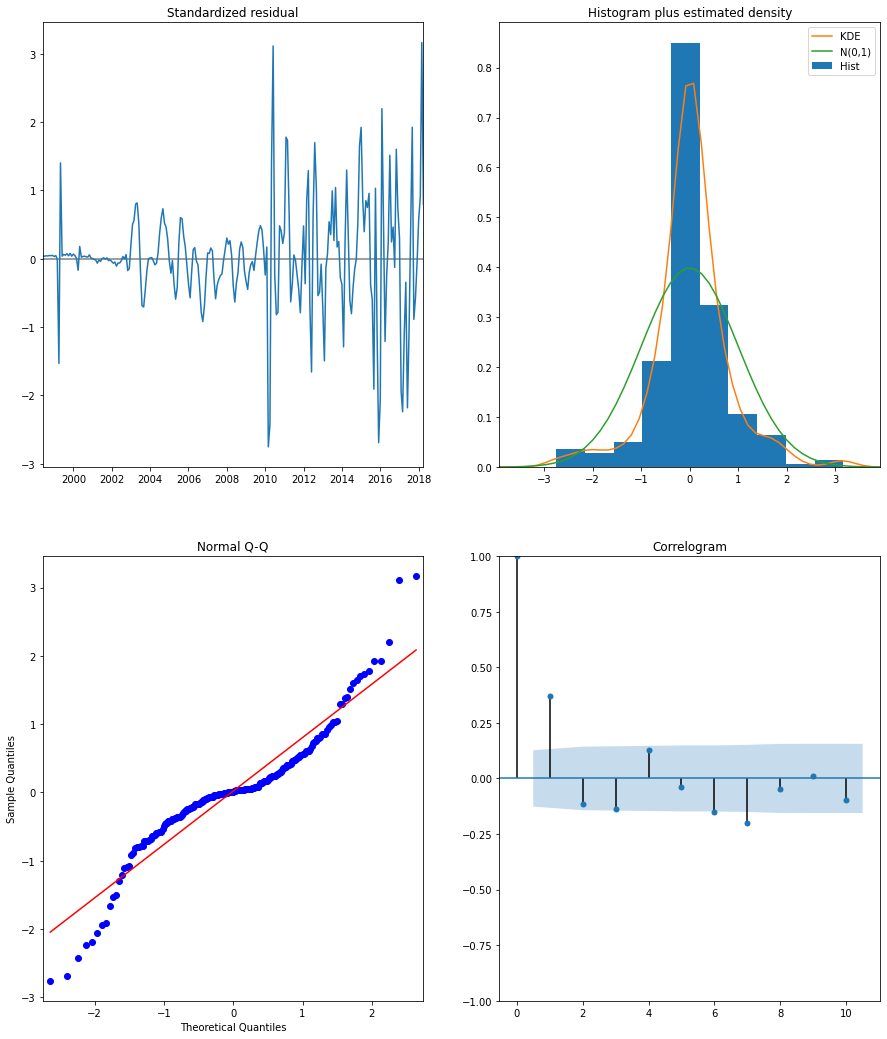

In [44]:
"""
In order to validate model, start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

get_prediction() and .conf_int() methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.
Get the confidence intervals for all predictions


year = '2014-01-01'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

11218	(1, 1, 0)	(1, 1, 1, 12)
"""
current_zip = 11218
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

# Note: Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_conf = pred.conf_int()

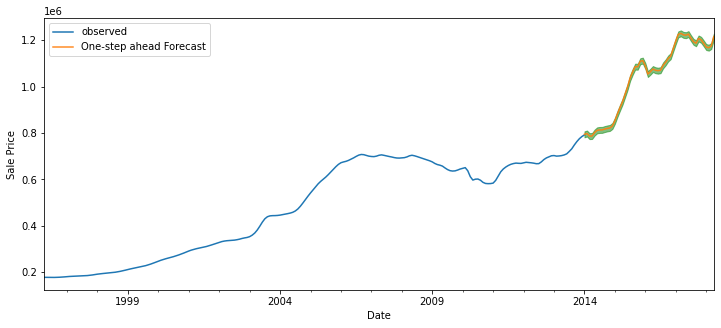

In [45]:
"""
plot the real and forecasted values of the time series to assess how well we did
Plot the confidence intervals overlapping the predicted values
The forecasts align with the true values as seen above, with overall increase trend.
"""
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = train_brk[11218]['1996':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [46]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

Also check for the accuracy of our forecasts using MSE (Mean Squared Error). This will provide us with the average error of our forecasts.

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal

Model was able to forecast the average daily real estate sales in the test set within 13,226.79 of the real sales. 
  sales range from around 659,200.000 to over 1,709,200.000.     
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test_brk[11218]['1996':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 65104775.98
The Root Mean Squared Error of our forecasts is 8068.75


In [47]:
train_brk[zipcode].describe().round(3)

count        214.000
mean     1319126.636
std       314705.269
min      1003700.000
25%      1037600.000
50%      1167000.000
75%      1567600.000
max      2202400.000
Name: 11217, dtype: float64

In [48]:
zip_params = output_df[output_df['zipcode']==11218]
zip_params

zipcode        pdq   seasonal_pdq         aic
13    11218  (1, 1, 0)  (1, 1, 1, 12)  5273.41146

In [49]:
zip_params['pdq']

13    (1, 1, 0)
Name: pdq, dtype: object

In [50]:
zip_params.pdq.values[0]

(1, 1, 0)

In [51]:
zip_params.seasonal_pdq.values[0]

(1, 1, 1, 12)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8598      0.043     19.904      0.000       0.775       0.944
ar.S.L12      -0.6398      0.081     -7.909      0.000      -0.798      -0.481
ma.S.L12      -0.1267      0.041     -3.067      0.002      -0.208      -0.046
sigma2       4.34e+07   4.27e-10   1.02e+17      0.000    4.34e+07    4.34e+07


MODEL DIAGNOSTICS


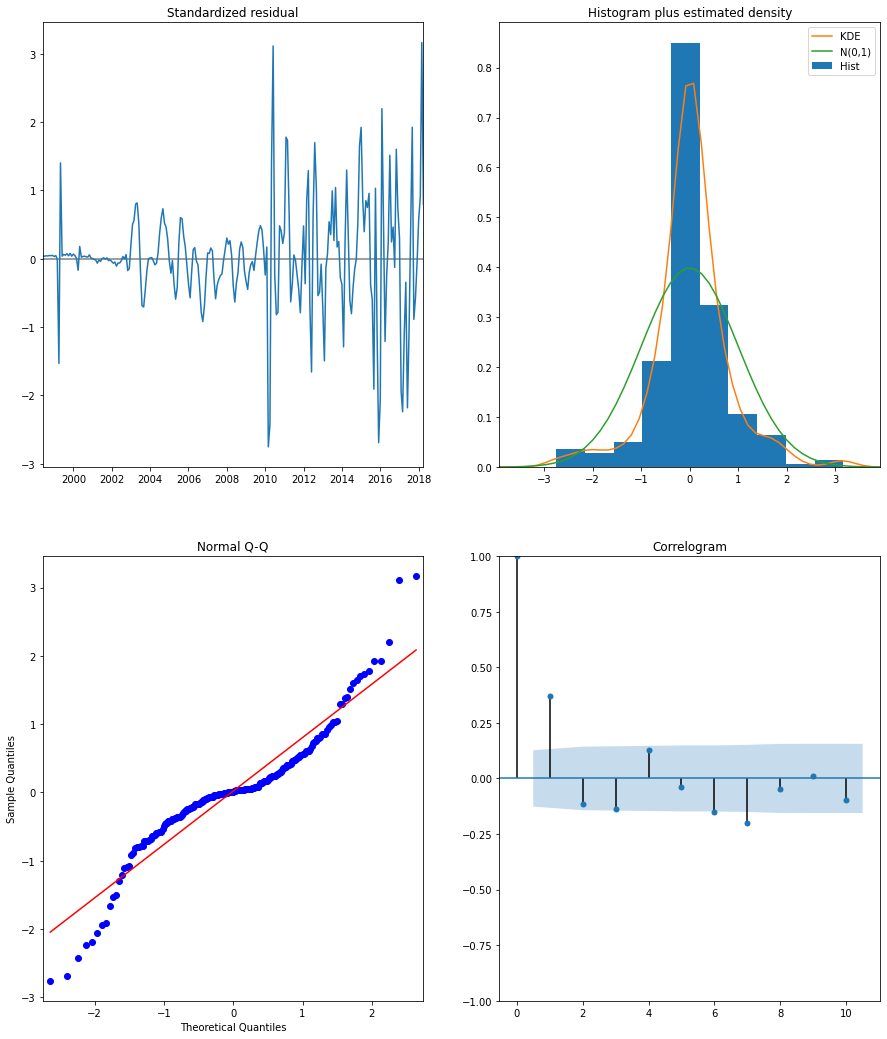

In [52]:
"""
we only use information from the time series up to a certain point, 
  and after that, forecasts are generated using values from previous forecasted time points.

pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

calculation for predictions post 2014.
"""
current_zip = 11218
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(zip_df[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [53]:
"""
Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. 
All forecasted values (yellow line) match pretty closely to the ground truth (blue line), 
  and are well within the confidence intervals of our forecast.
  
before used 2004
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()
"""

def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

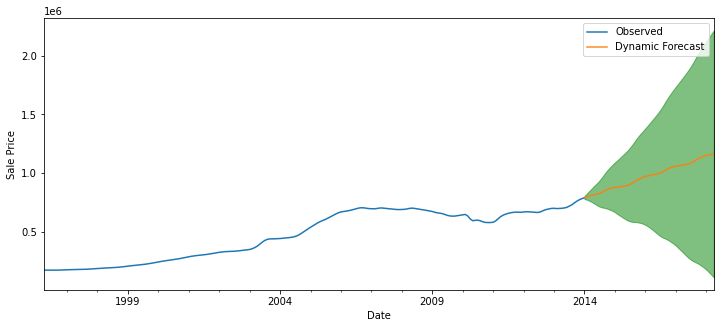

In [54]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train_brk[current_zip])
prediction_visual

In [55]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train_brk[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 6201214.15
The Root Mean Squared Error of our forecasts is 2490.22


### **Return on Investment DataFrame**

In [56]:
"""
.get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.

prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()
"""
# Get forecast --- steps ahead in future
prediction = output_sarima.get_forecast(steps=36, dynamic=True)
prediction.predicted_mean

# Get confidence intervals of forecasts
predict_conf = prediction.conf_int()


In [57]:
#Ben
steps = 36
# Get forecast --- steps ahead in future
prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)

In [58]:
def my_function(prediction_object, zip):
  
  df_Summary = pd.concat([pd.DataFrame({f'Predicted_Mean {zip}':prediction_object.predicted_mean}), prediction_object.conf_int()],axis = 1)
  my_sample = df_Summary.iloc[[0, -1]].round(3)

  return my_sample

In [59]:
my_output = my_function(prediction_object, zip='11218')
my_output

Predicted_Mean 11218  lower 11218  upper 11218
2018-05-01           1244285.316  1231373.565  1257197.067
2021-04-01           1715735.943  1064307.520  2367164.366

In [60]:
"""
​	  
ROI= 
Cost of Investment
Current Value of Investment−Cost of Investment
​	 
"""
def my_roi(cost, current):
  return (current - cost) / cost


In [61]:
cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]

In [62]:

current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]

In [63]:
#upper lower end
roi_dic = {}

cost = my_output.iloc[0,0]
current = my_output.iloc[-1,0]
current_lower = my_output.iloc[-1,1]
current_upper = my_output.iloc[-1,2]


my_roi(cost, current)
roi_dic['roi'] = my_roi(cost, current)
roi_dic['roi_lower'] = my_roi(cost, current_lower)
roi_dic['roi_upper'] = my_roi(cost, current_upper)

roi_dic

{'roi': 0.3788927032552073,
 'roi_lower': -0.14464351036350256,
 'roi_upper': 0.9024289168739171}

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7634      0.048     16.053      0.000       0.670       0.857
ar.S.L12      -0.5588      0.080     -7.018      0.000      -0.715      -0.403
ma.S.L12      -0.1457      0.046     -3.147      0.002      -0.237      -0.055
sigma2      3.679e+07   2.78e-10   1.32e+17      0.000    3.68e+07    3.68e+07


MODEL DIAGNOSTICS
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5376      0.094      5.721      0.000       0.353       0.722
ar.L2          0.1454      0.089      1.629      0.103      -0.029       0.320
ma.L1          1.2099      0.041     29.251      0.000       1.129       1.291
ma.S.L12      -0.5381      0.094     -5.742      0.000      -0.722      -0.354
ma.S.L24       0.0827      0.066

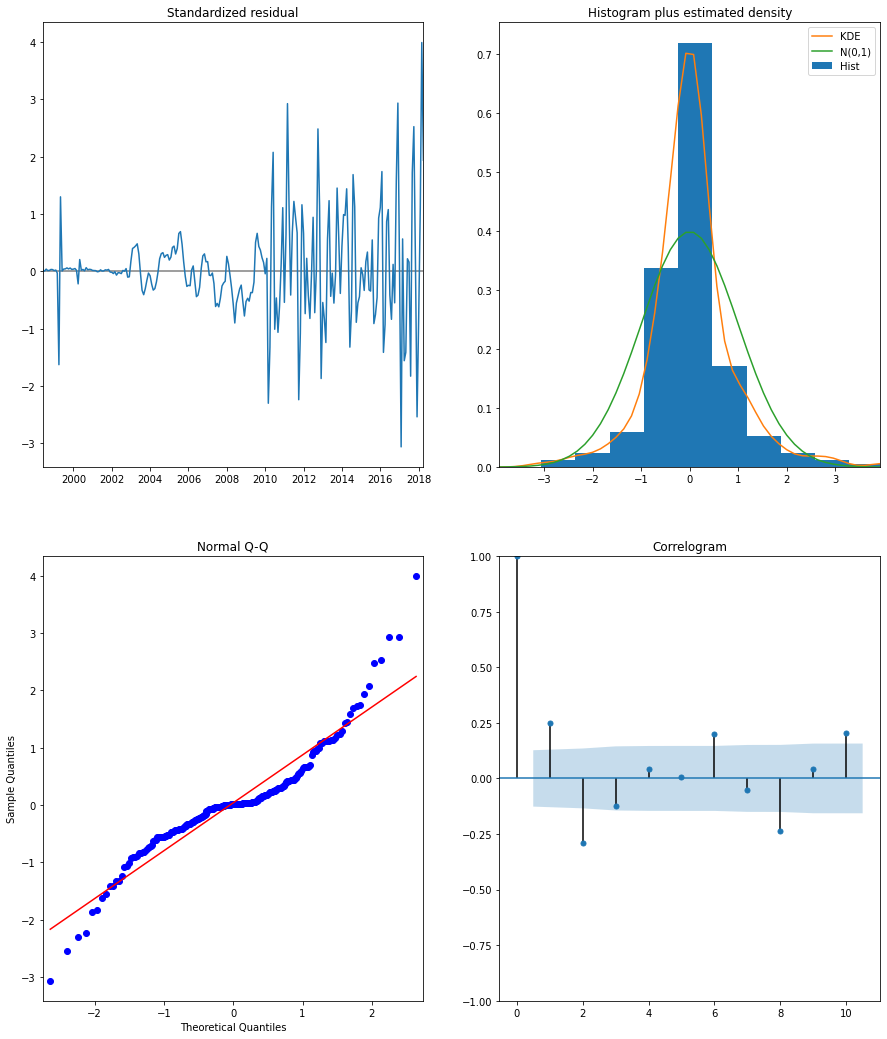

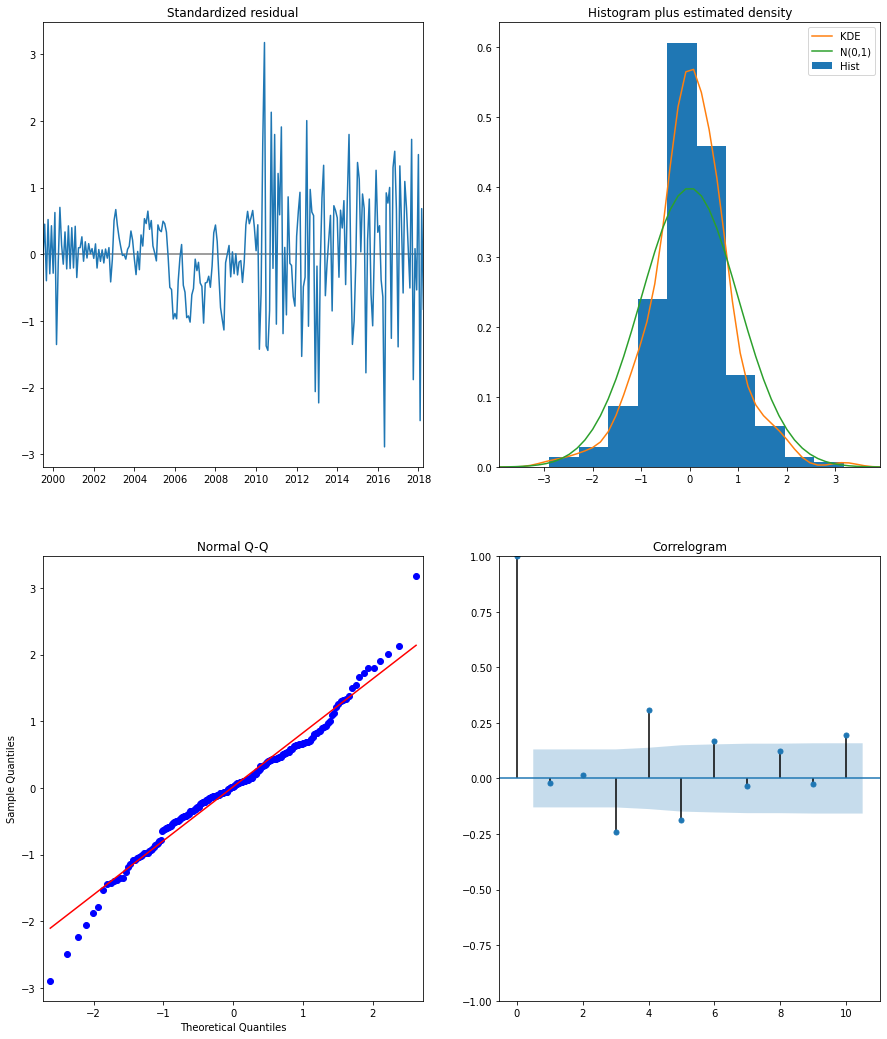

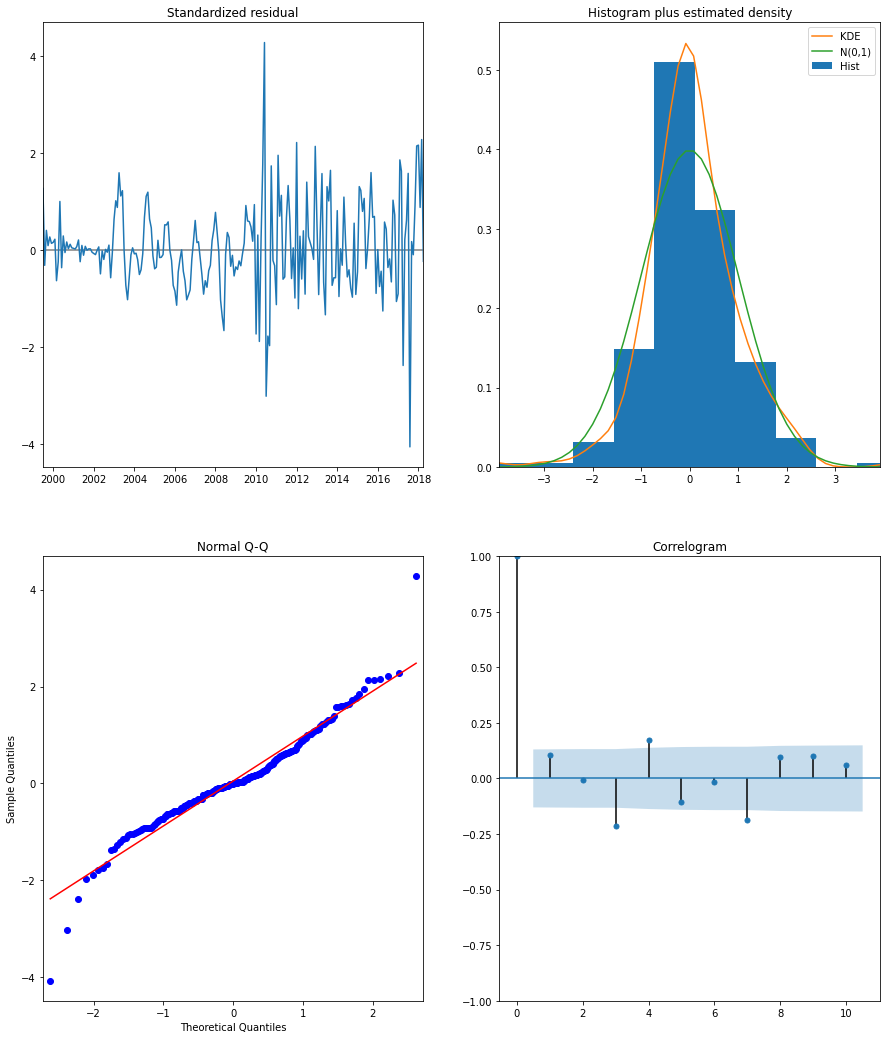

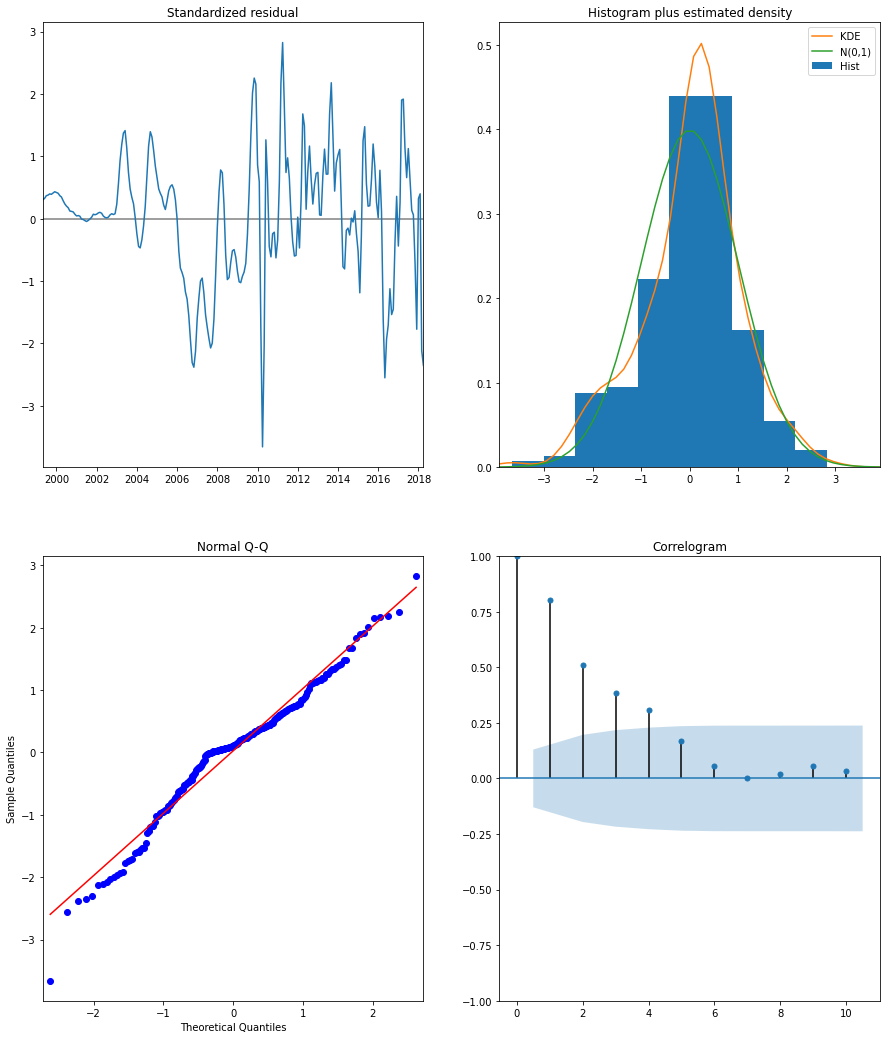

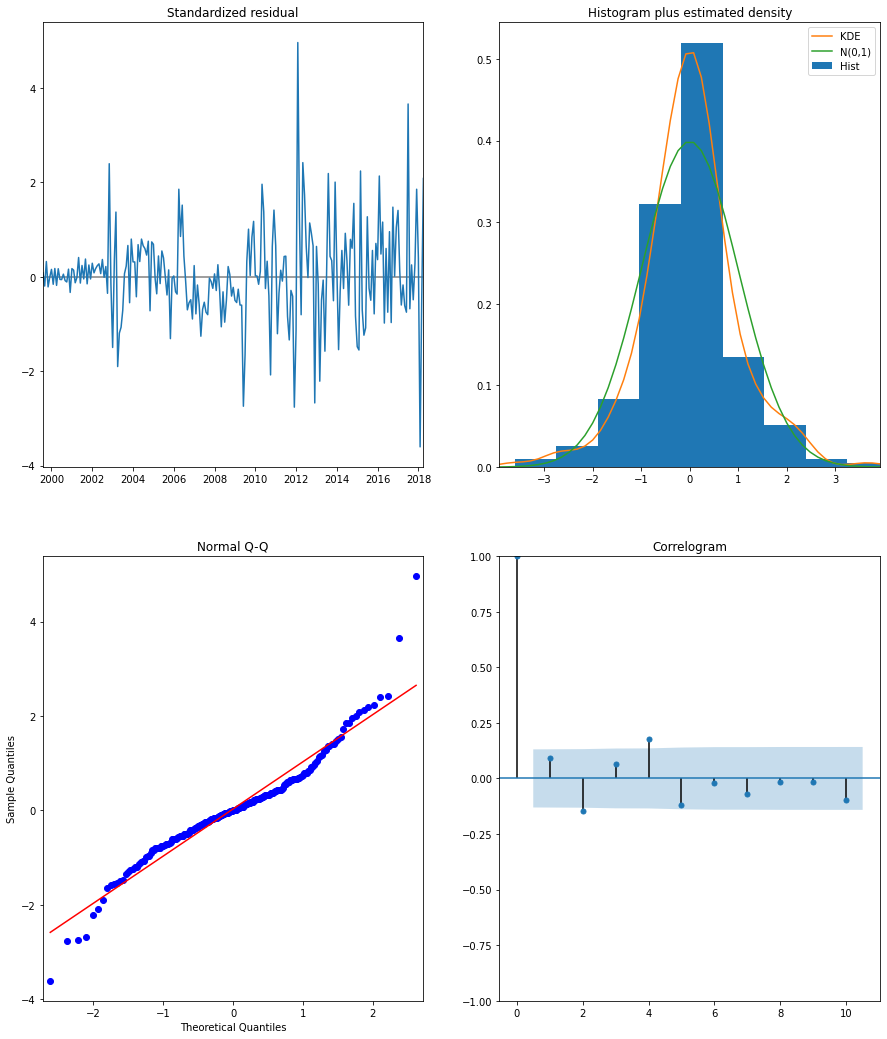

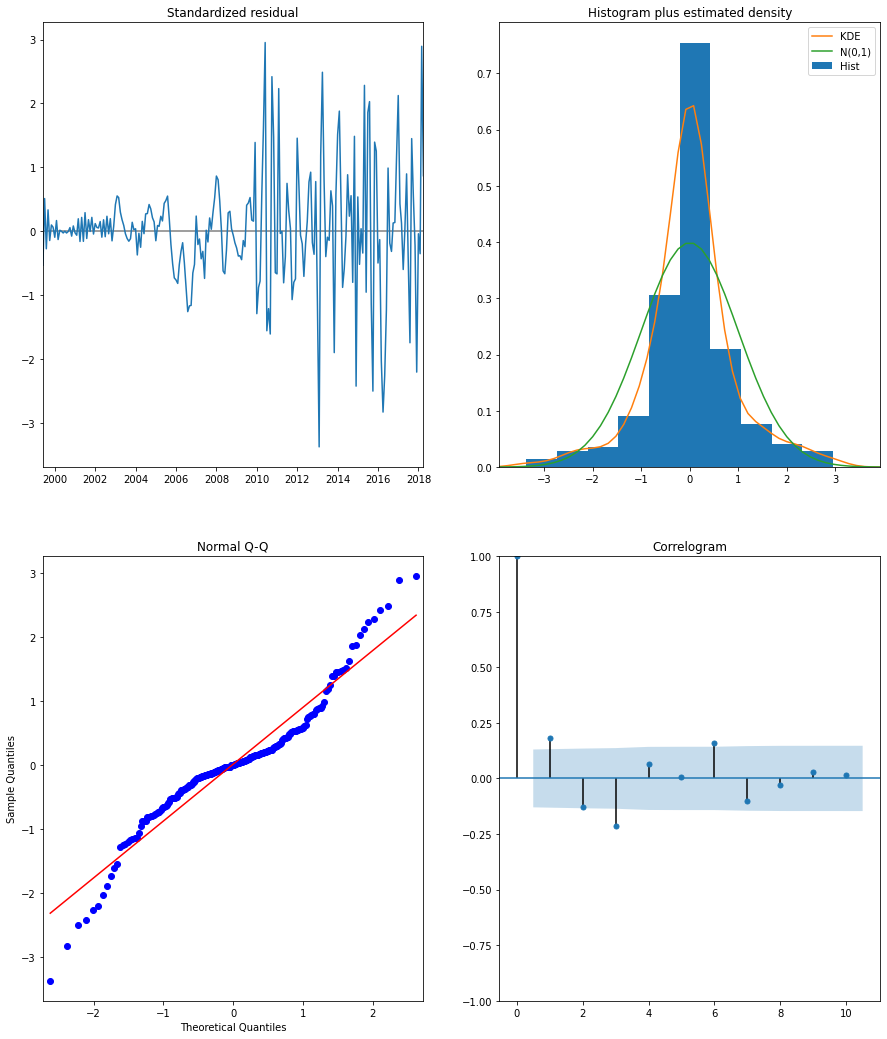

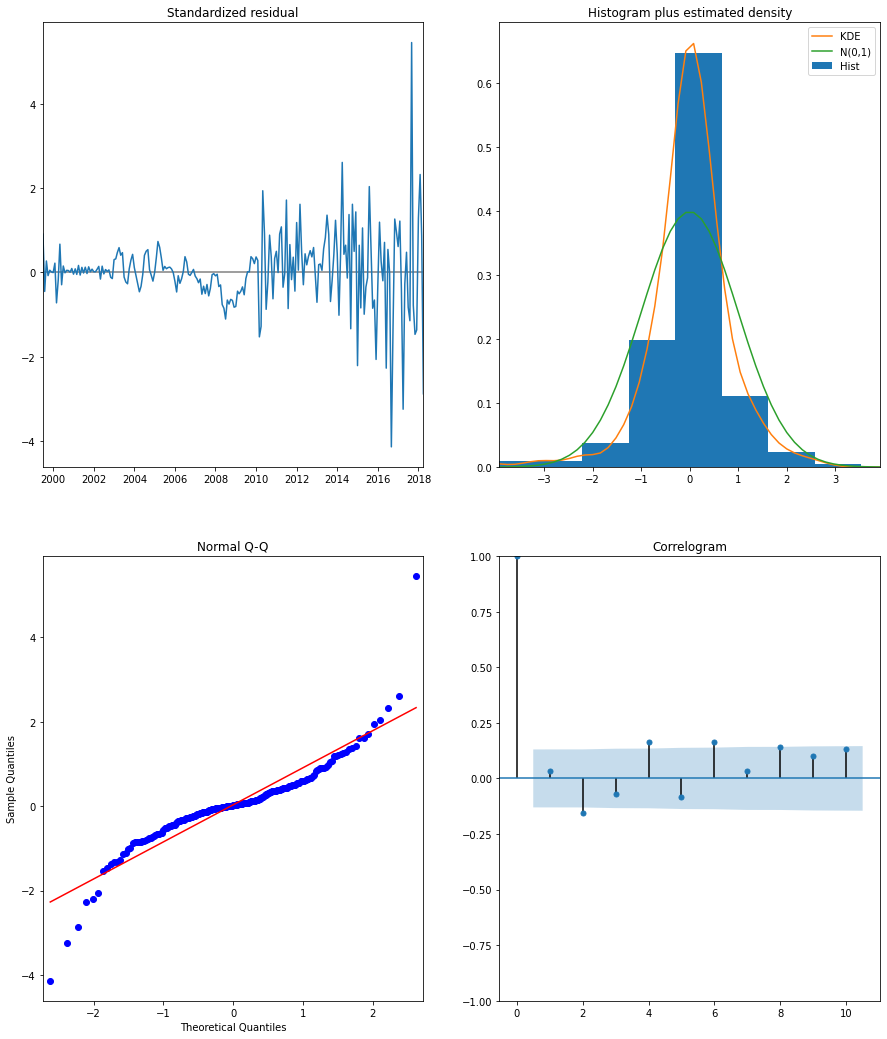

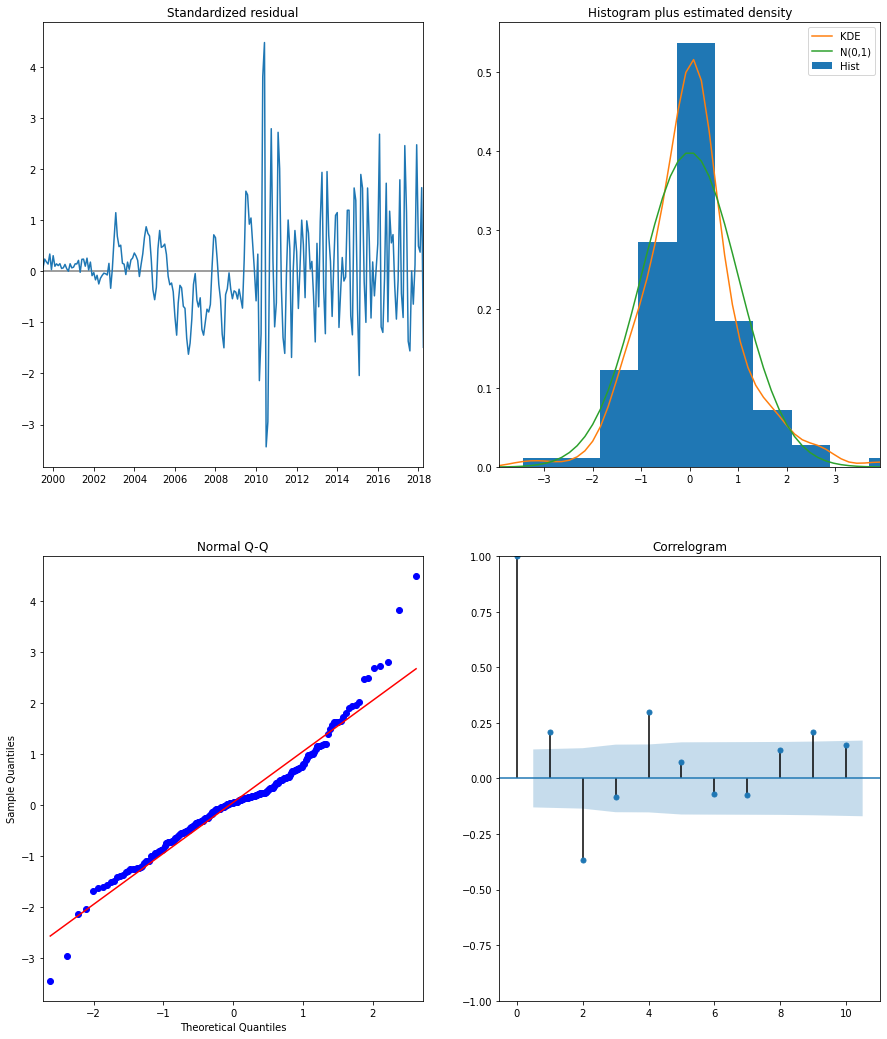

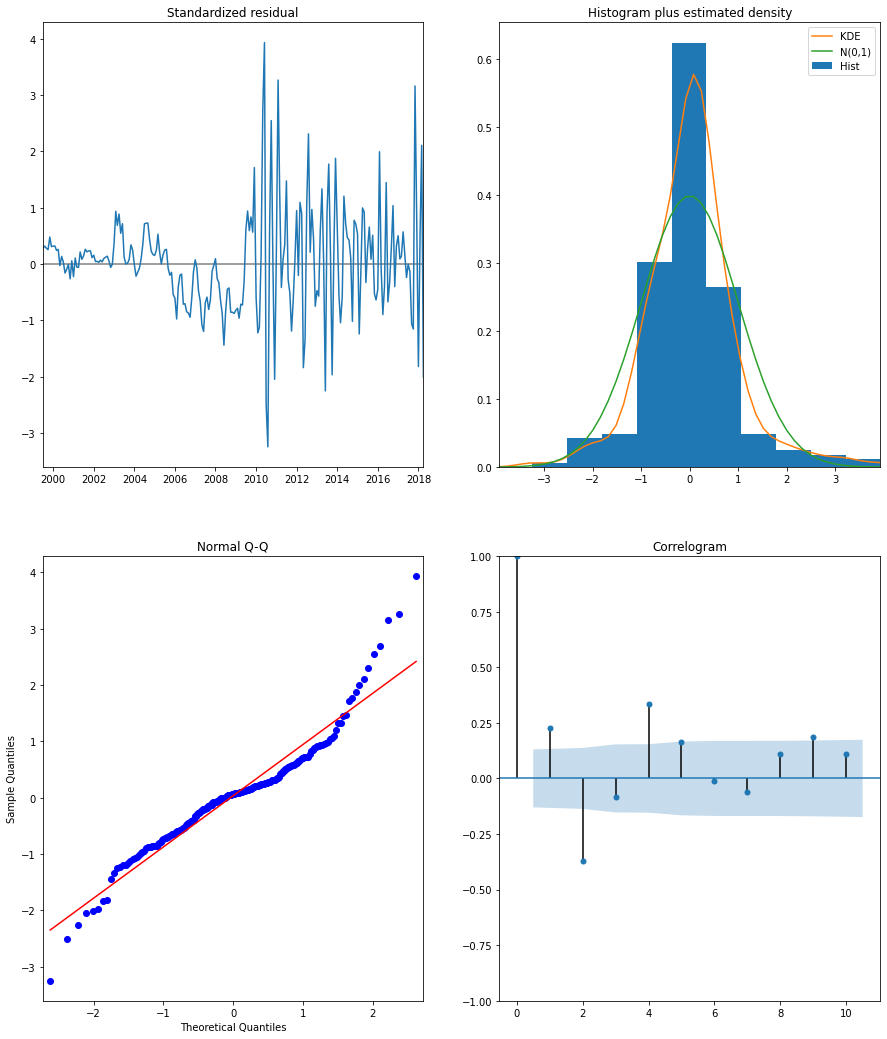

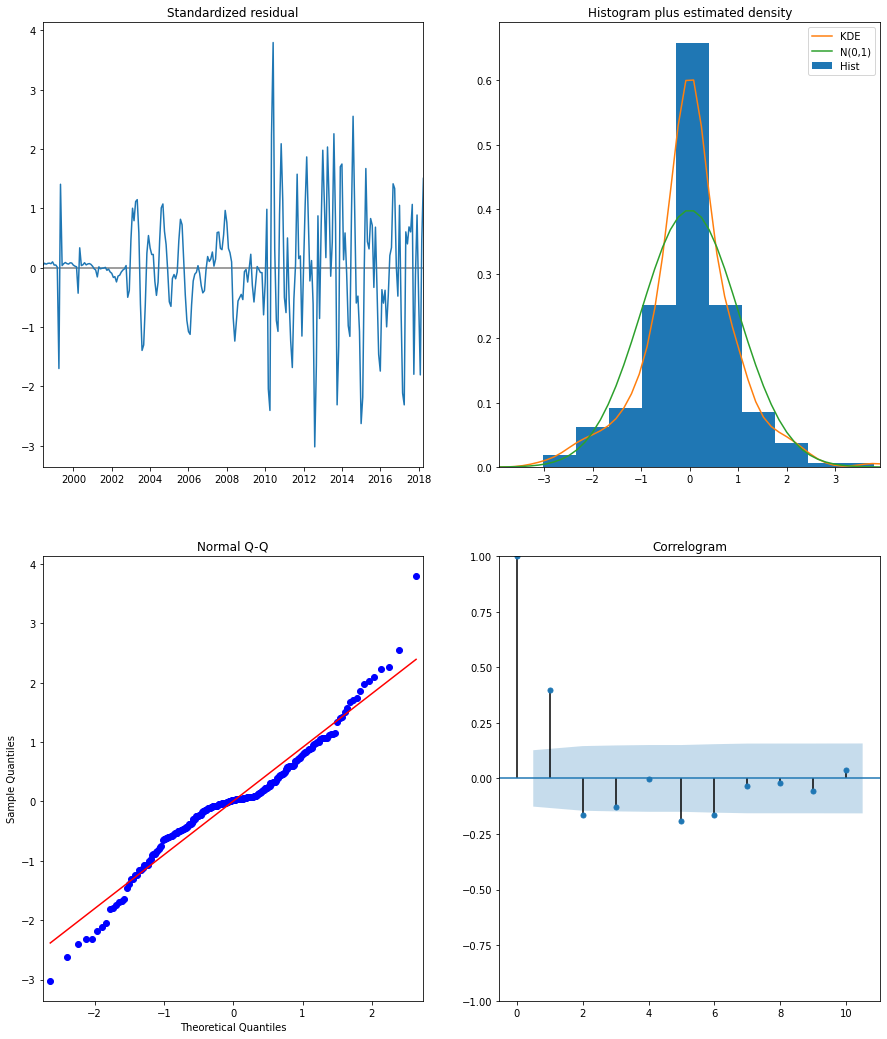

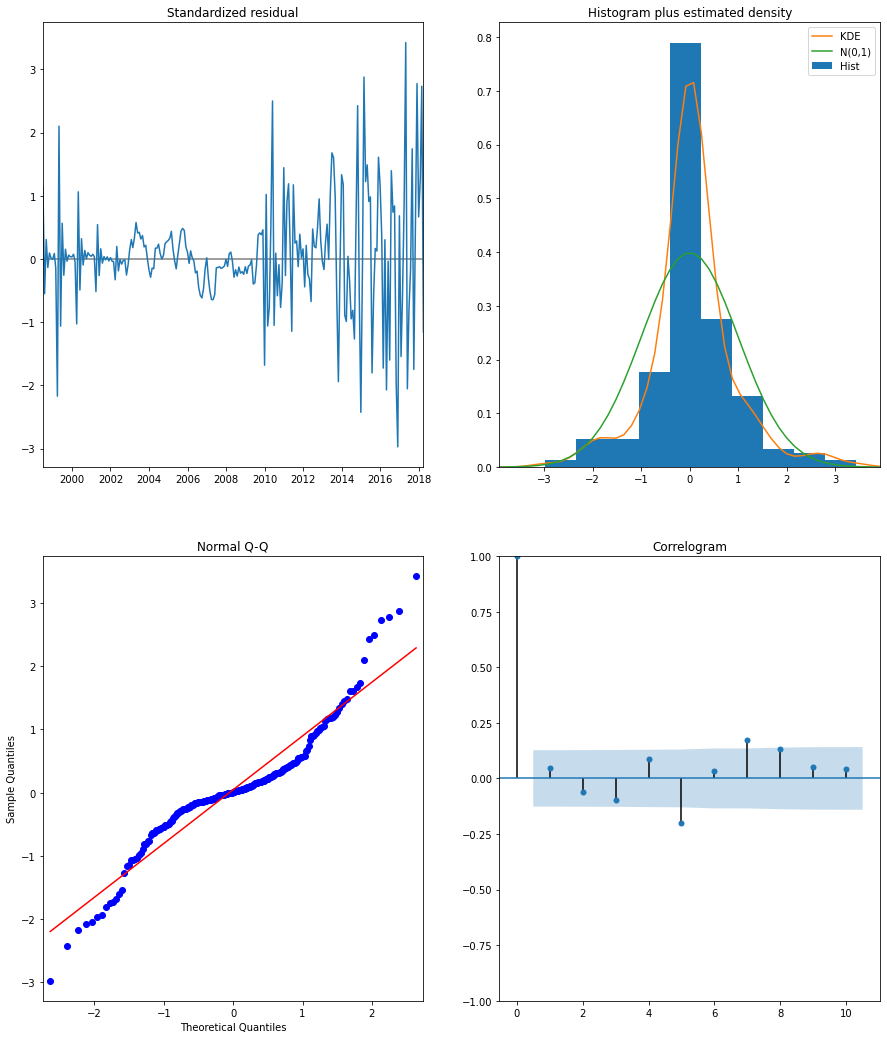

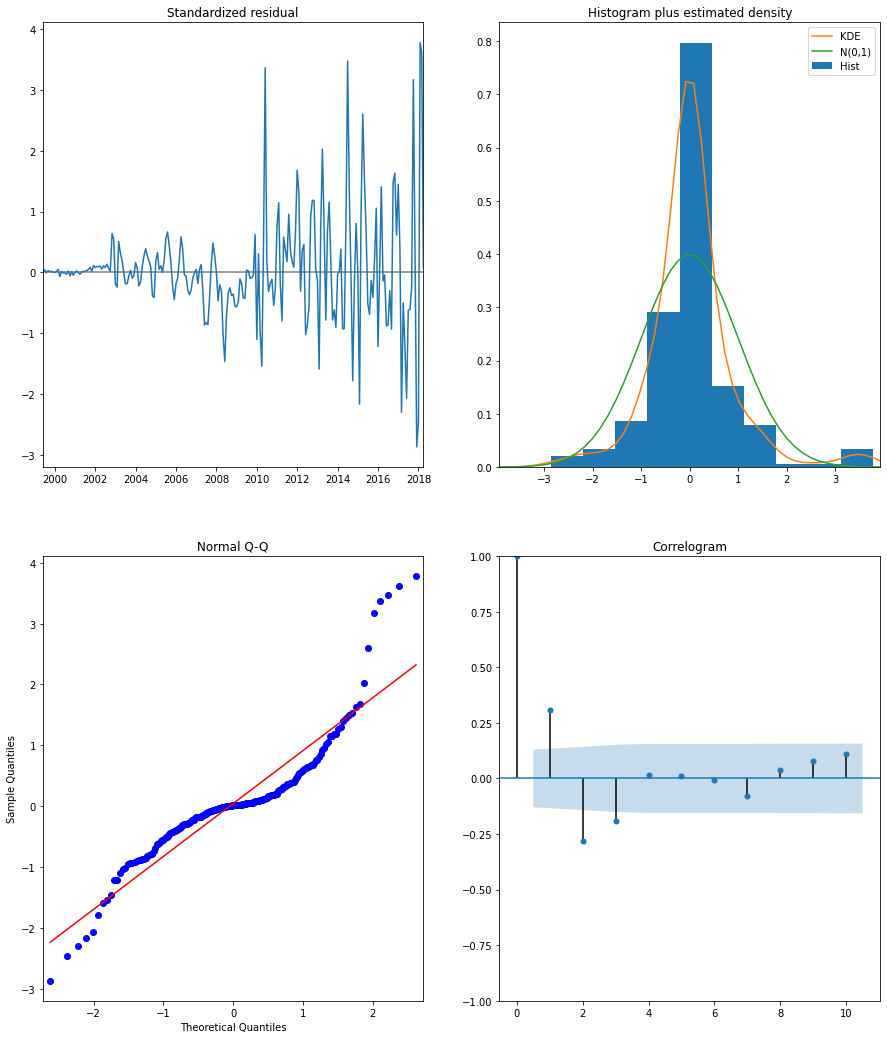

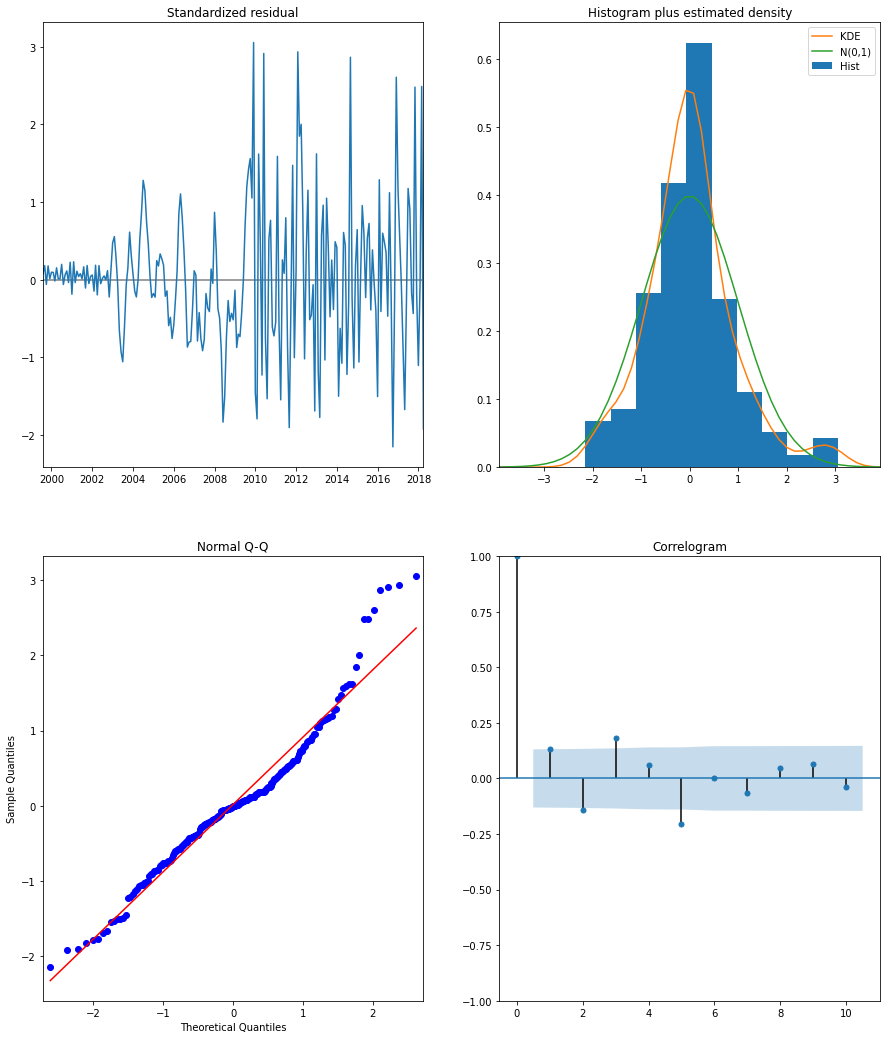

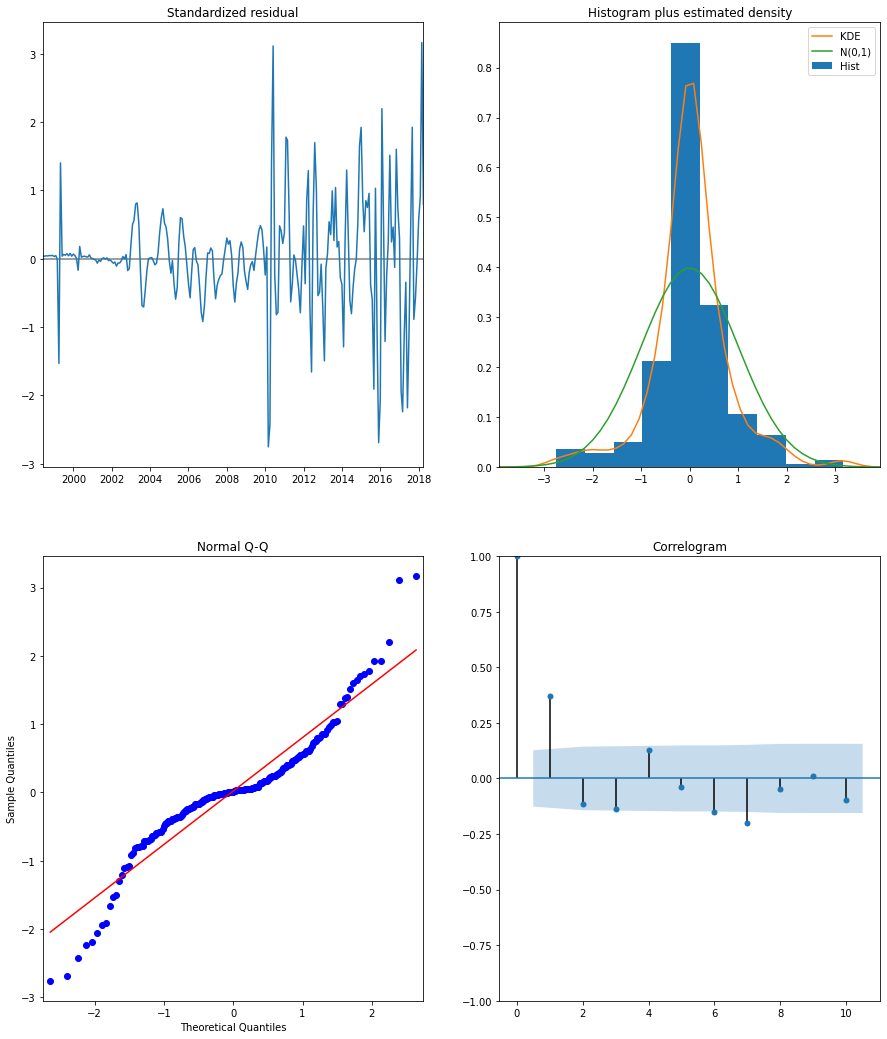

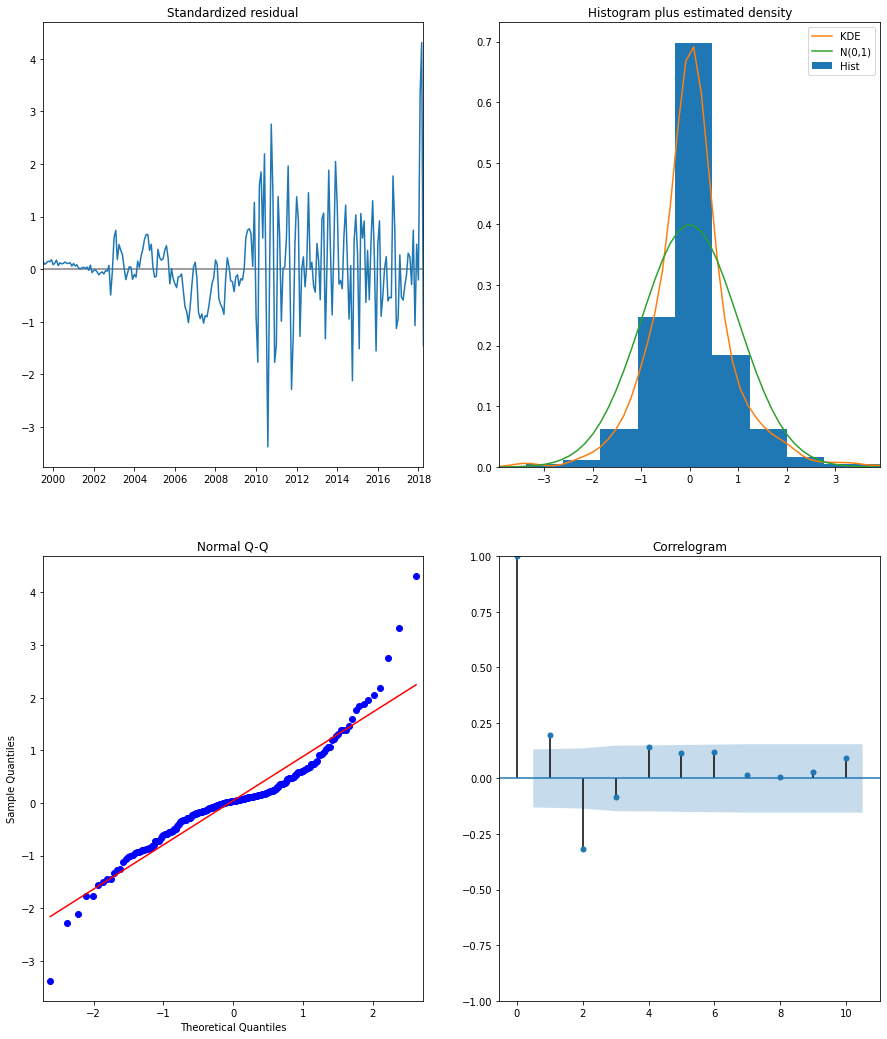

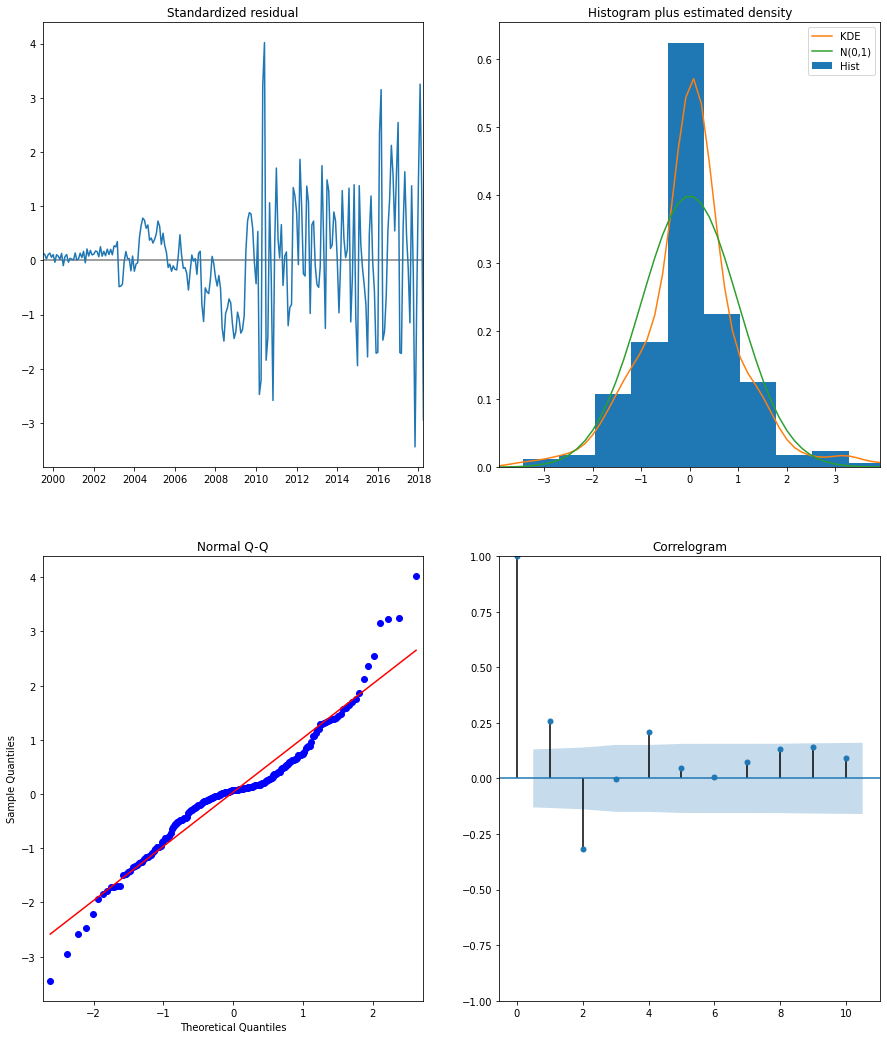

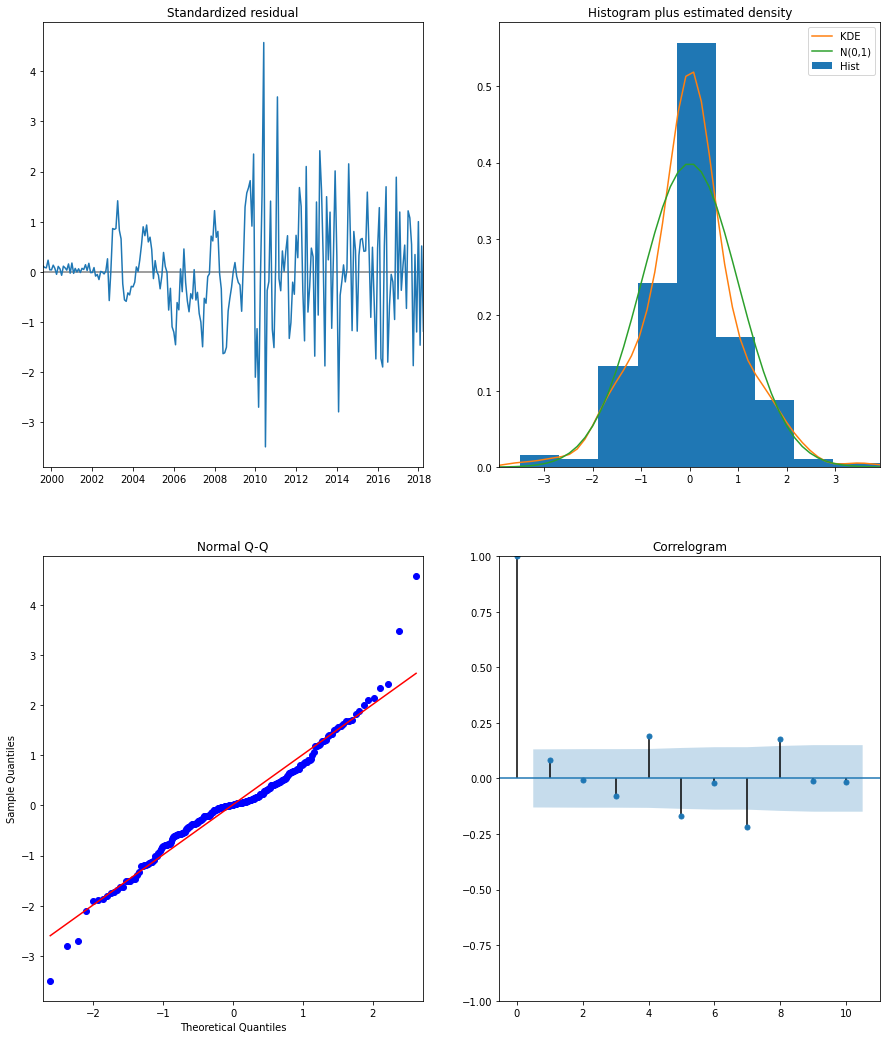

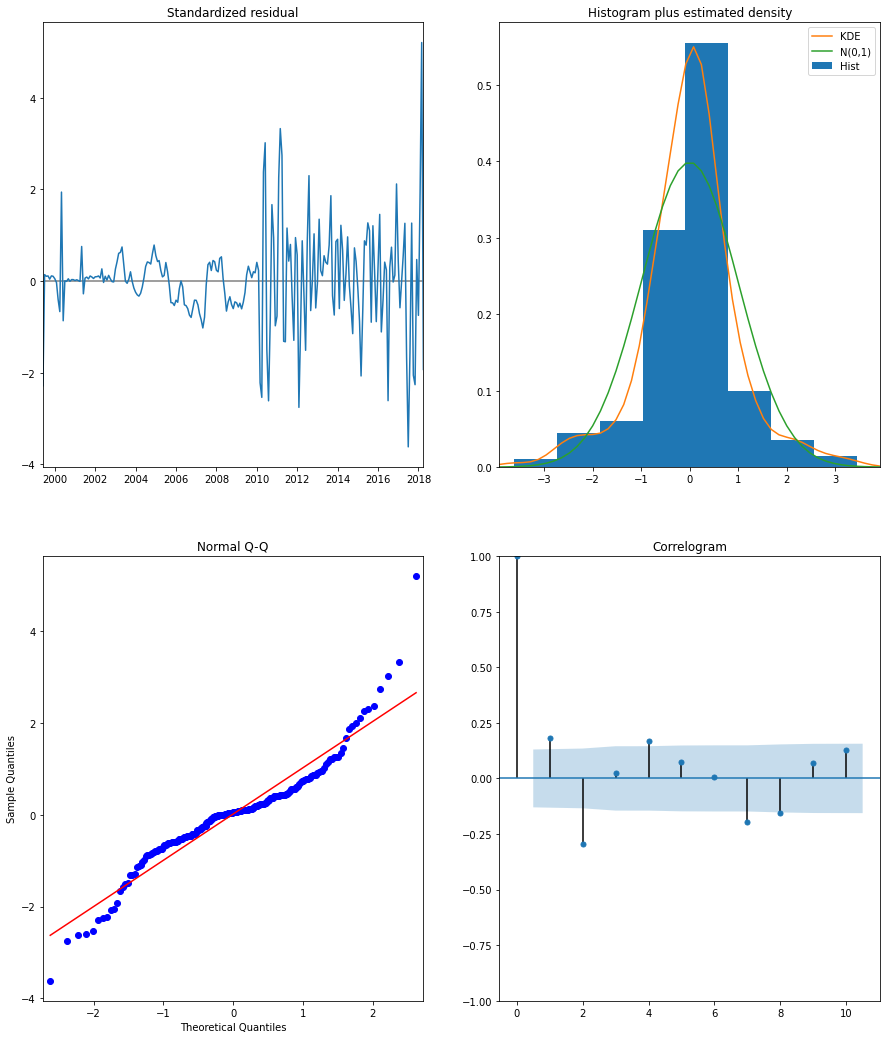

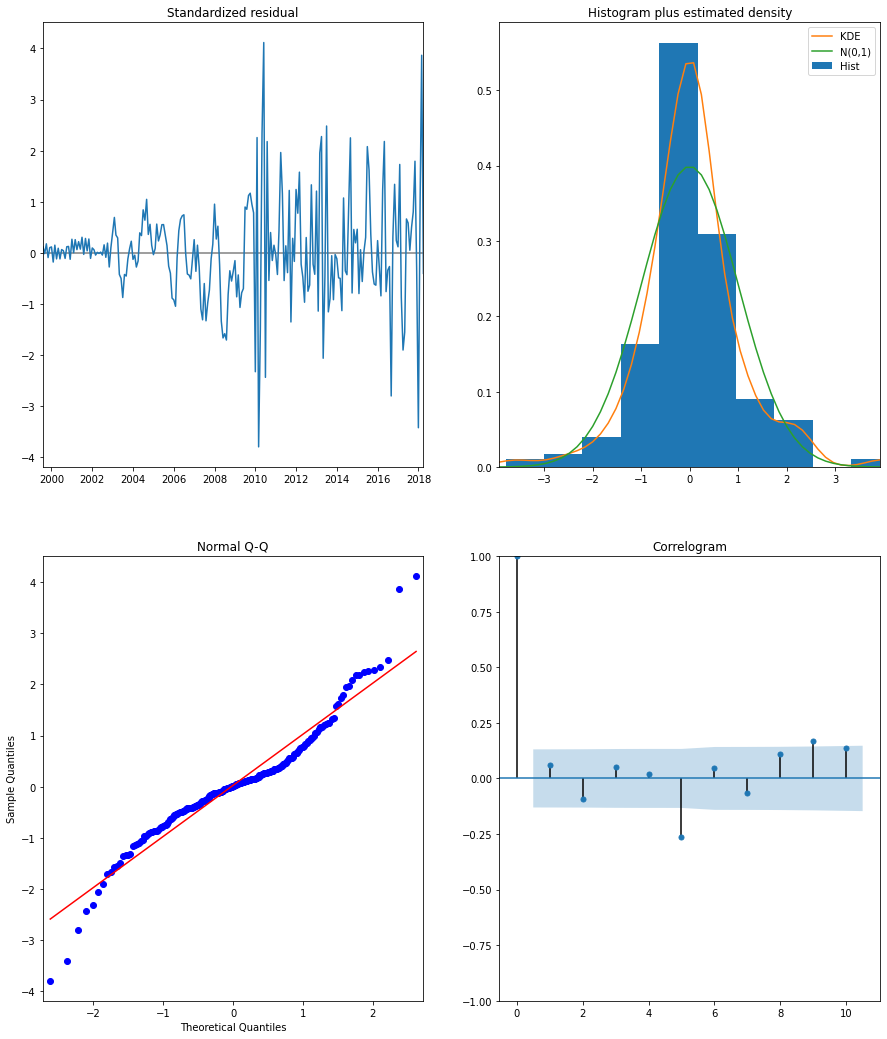

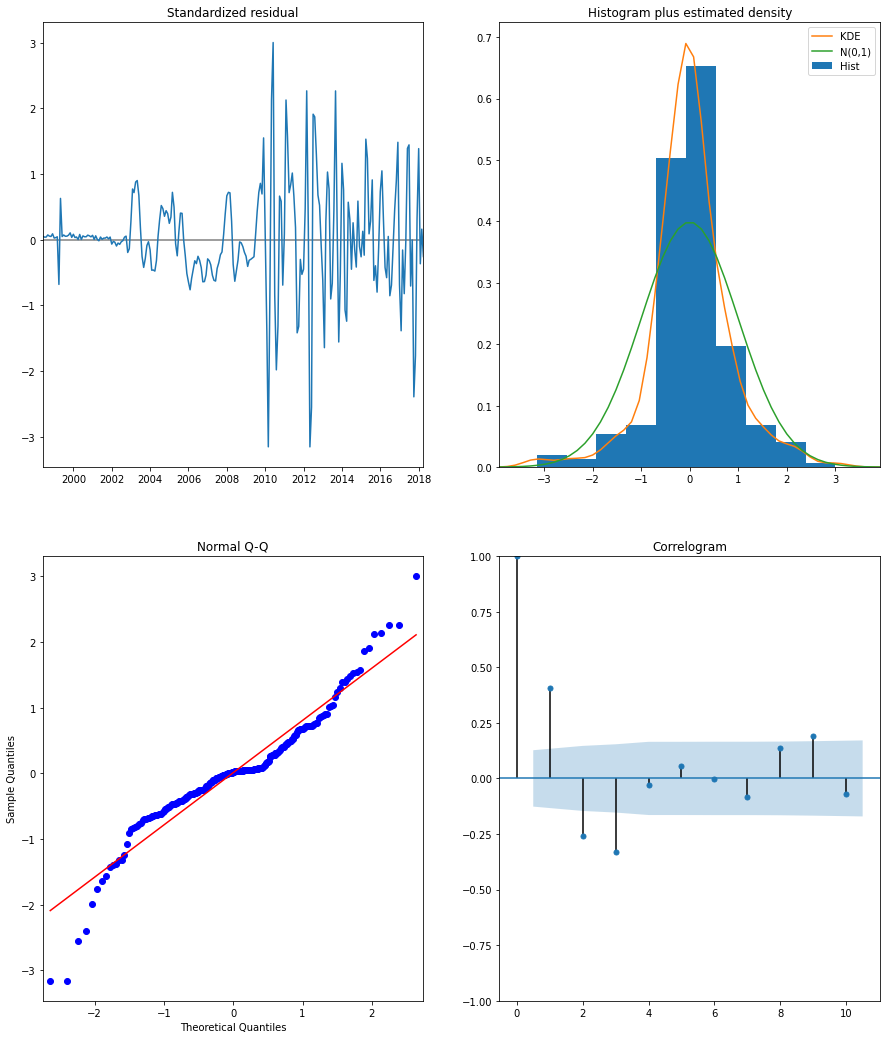

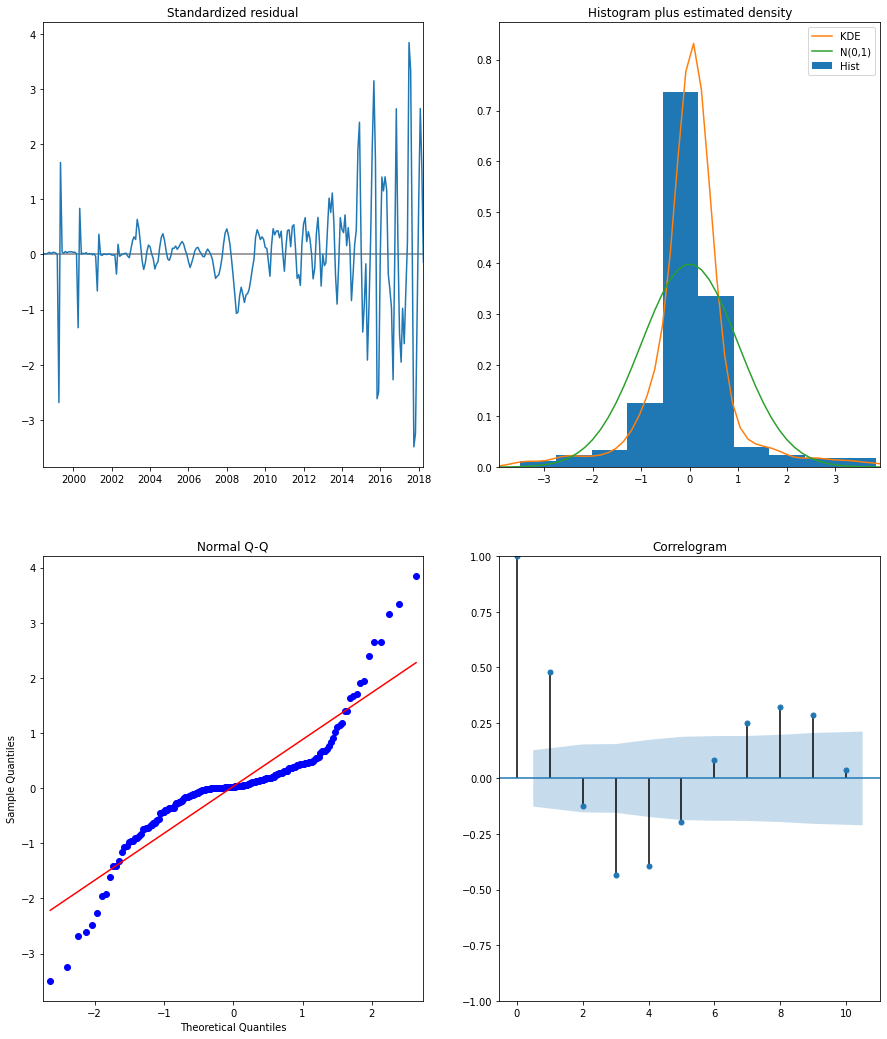

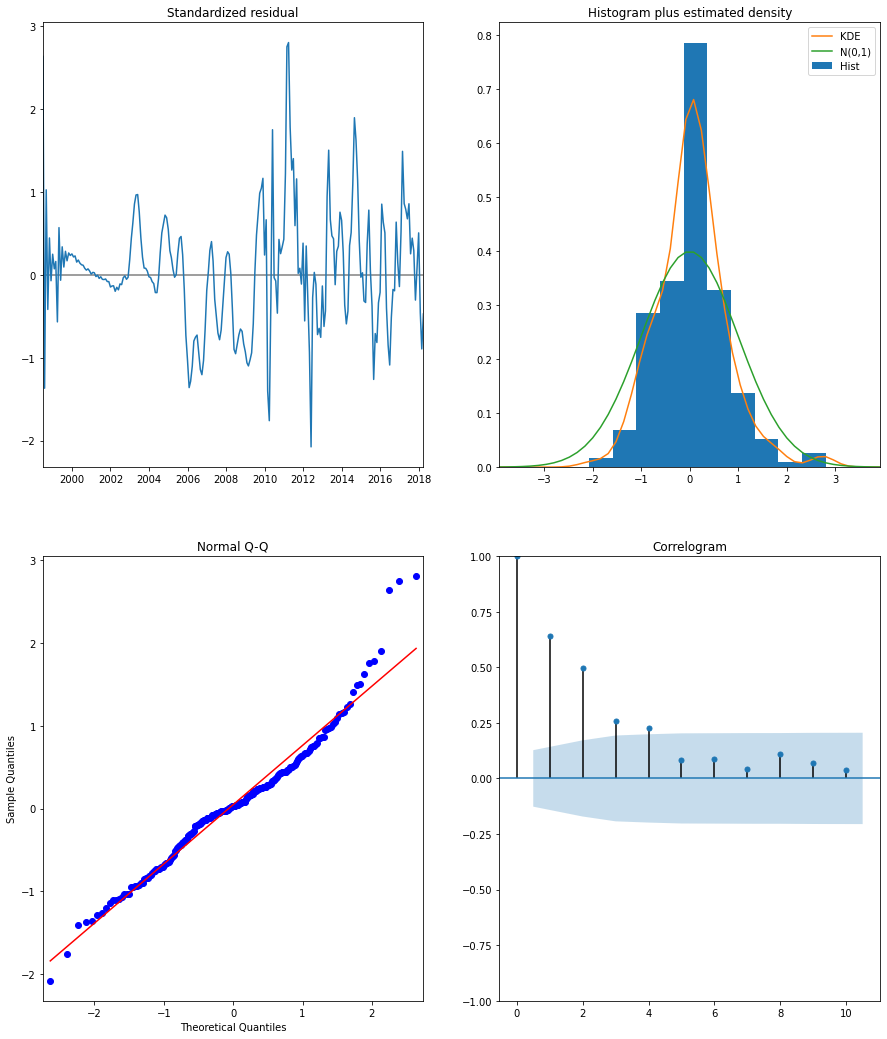

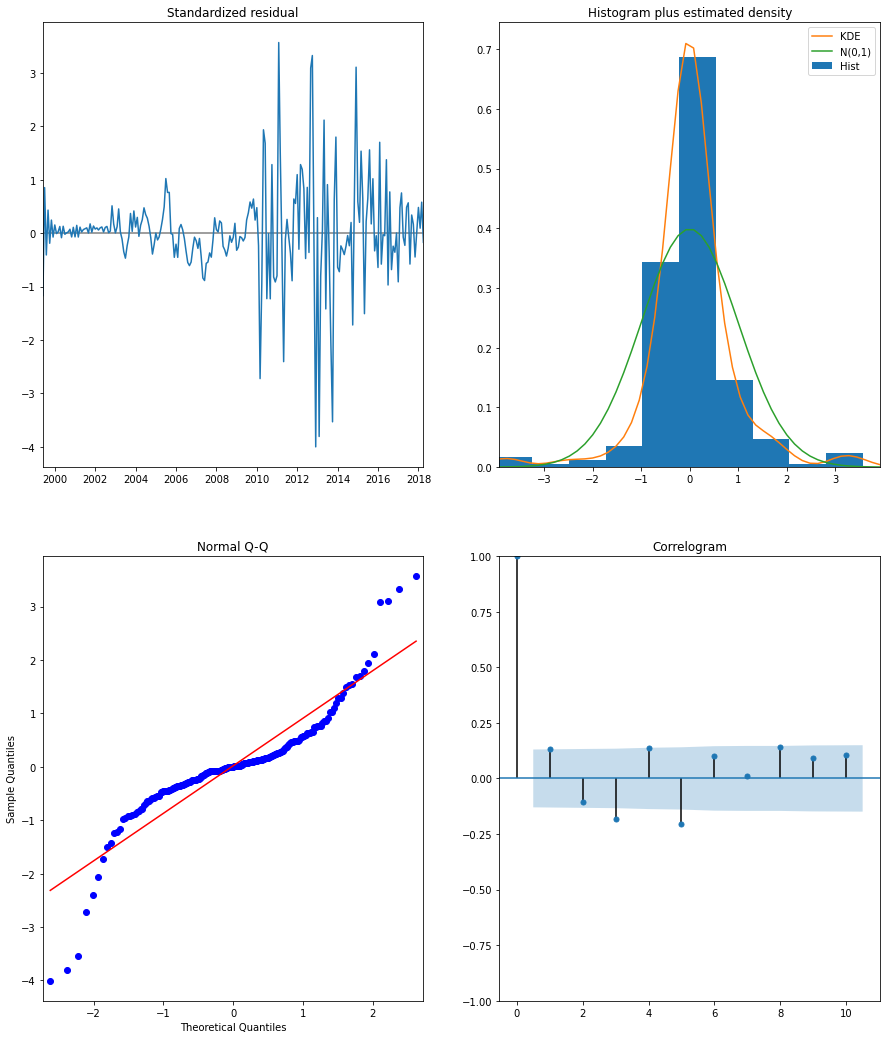

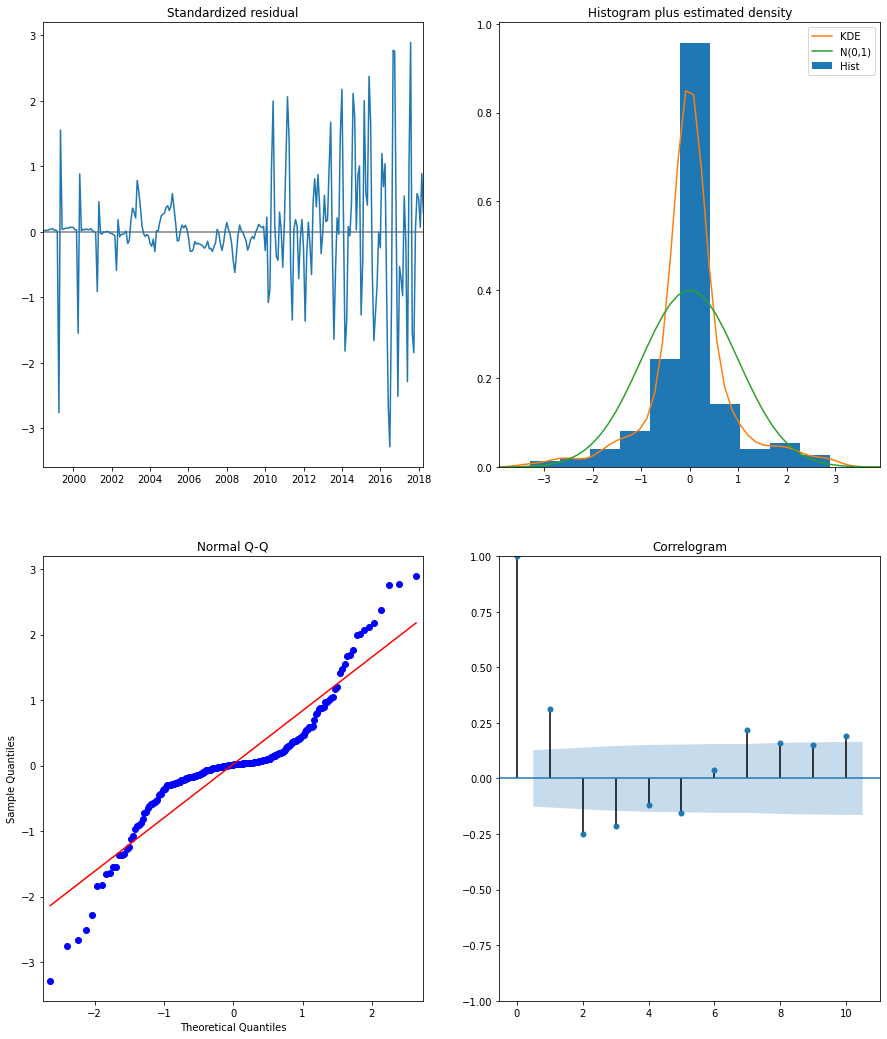

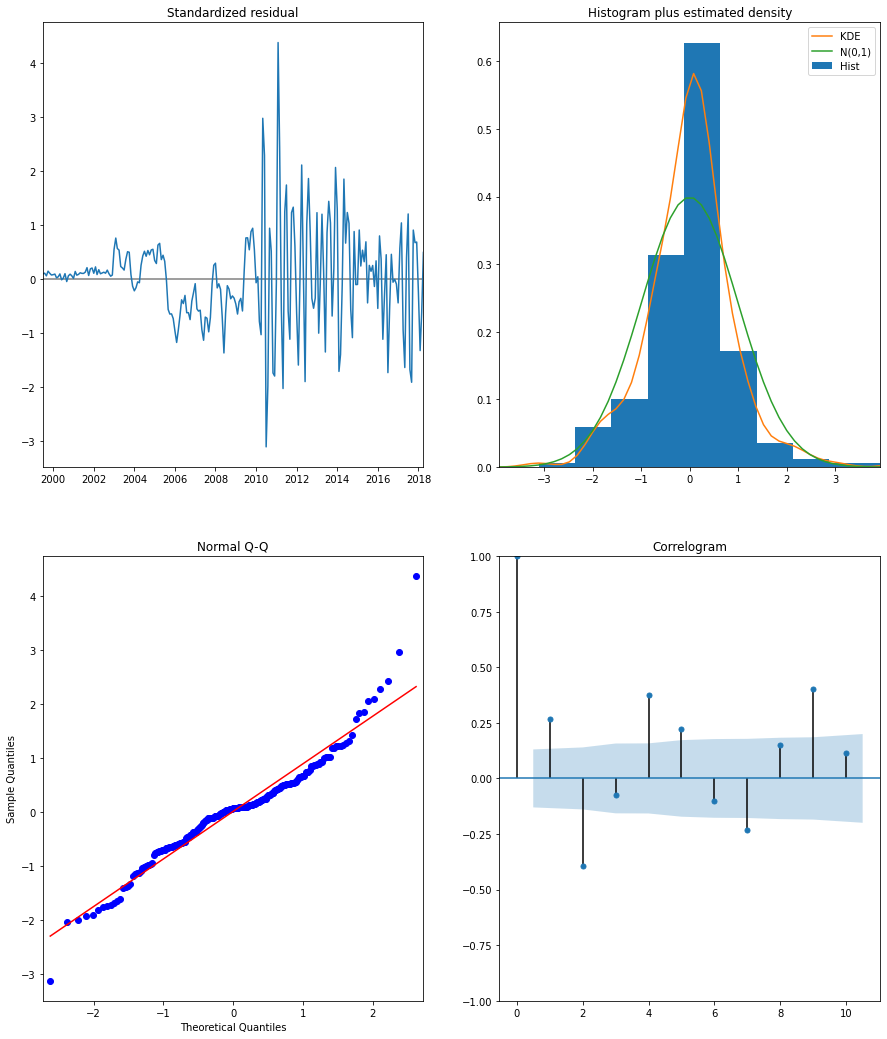

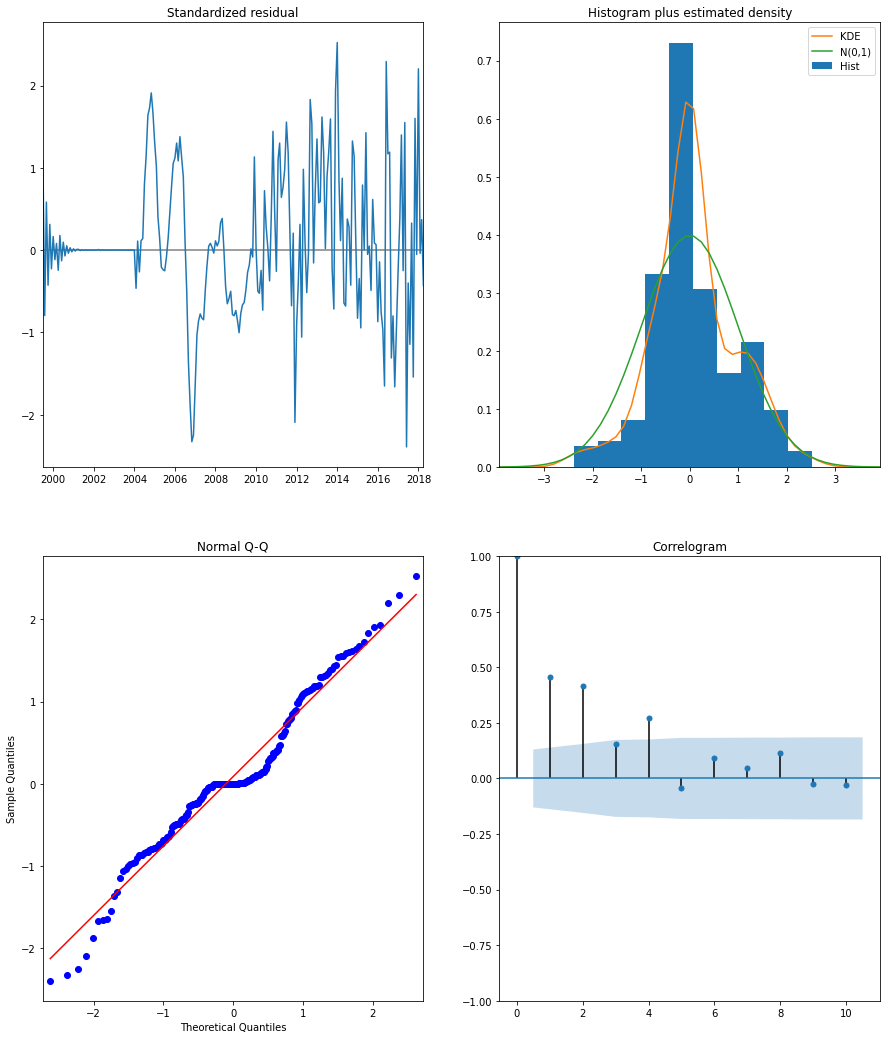

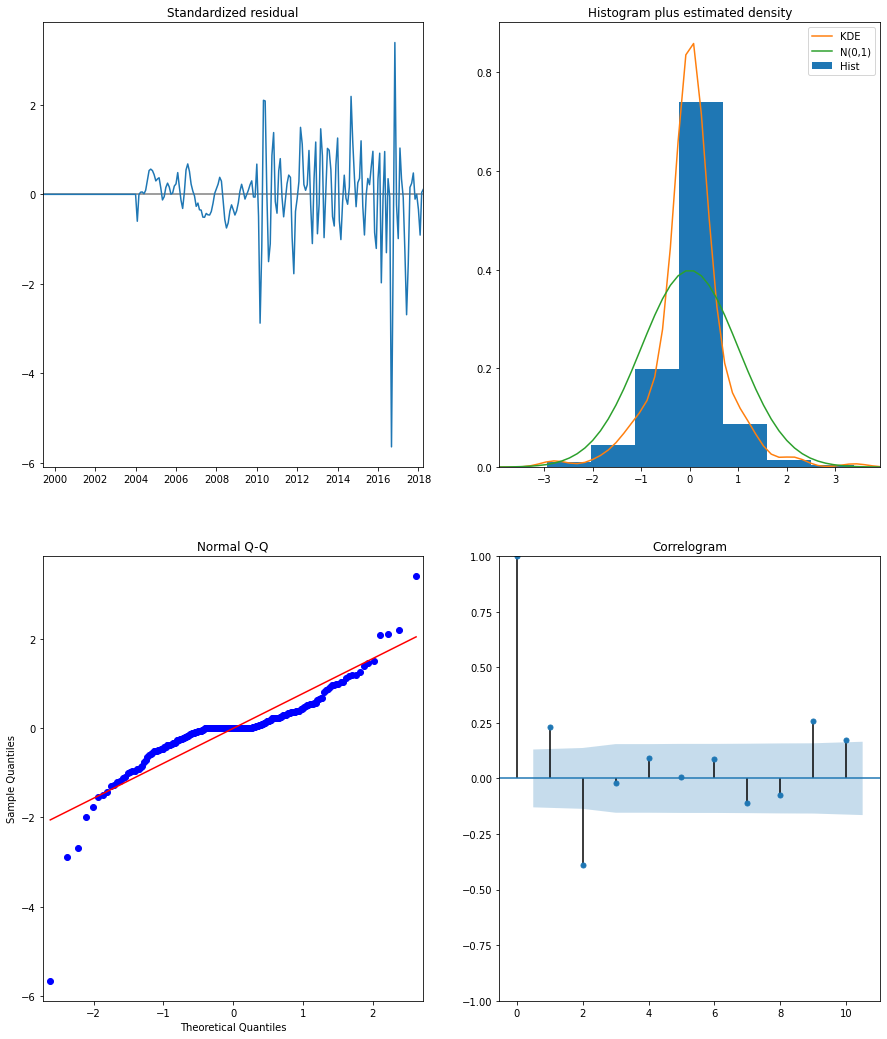

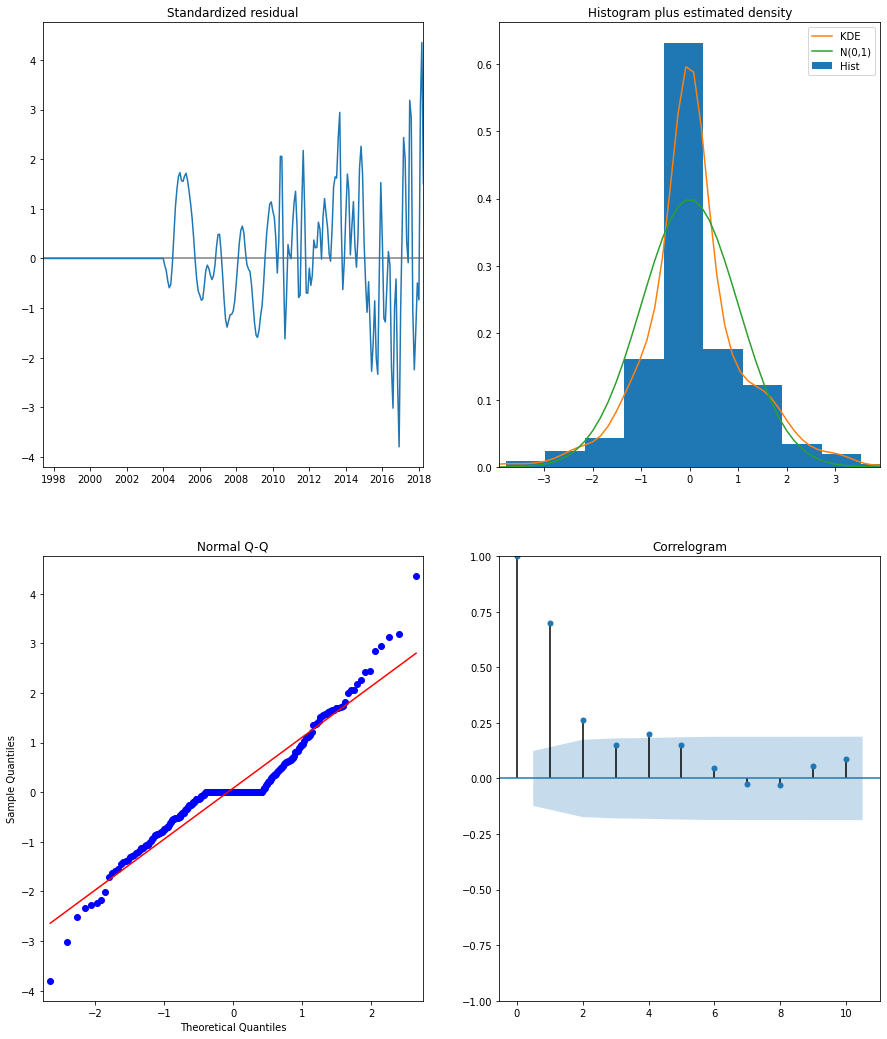

In [64]:
zip_rois={}
steps = 36

#def zipcode_roi(output_df,):
for zipcode in output_df['zipcode'].unique():
  pdq = output_df.loc[ output_df['zipcode']==zipcode, 'pdq'].iloc[0] 
  seasonal = output_df.loc[ output_df['zipcode']==zipcode, 'seasonal_pdq'].iloc[0] 
  df_ts = zip_df[zipcode]


  output_sarima = fit_ARIMA(df_ts, order=pdq, seasonal_order=seasonal)
  prediction_object = output_sarima.get_forecast(steps=steps, dynamic=True)
  my_output = my_function(prediction_object, zip=zipcode)
  
  roi_dic = {}

  cost = my_output.iloc[0,0]
  current = my_output.iloc[-1,0]
  current_lower = my_output.iloc[-1,1]
  current_upper = my_output.iloc[-1,2]

  my_roi(cost, current)
  roi_dic['roi'] = my_roi(cost, current)
  roi_dic['roi_lower'] = my_roi(cost, current_lower)
  roi_dic['roi_upper'] = my_roi(cost, current_upper)

  zip_rois[zipcode] = pd.Series(roi_dic)
ROI = pd.DataFrame(zip_rois)

In [65]:
roi_df = ROI.T 
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'zipcode'}, inplace=True)
roi_df

zipcode       roi  roi_lower  roi_upper
0     11226  0.457944   0.052723   0.863166
1     11235  0.207215  -0.084564   0.498994
2     11230  0.378108   0.098586   0.657631
3     11209  0.114992   0.005002   0.224982
4     11212  0.371624  -0.027713   0.770960
5     11214  0.205318  -0.100338   0.510974
6     11221  0.232899  -0.073477   0.539276
7     11229  0.258523   0.070452   0.446594
8     11234  0.193522  -0.013736   0.400781
9     11215  0.127581  -0.297335   0.552496
10    11211  0.354534   0.020138   0.688931
11    11233  0.425923   0.062776   0.789070
12    11236  0.288035  -0.163018   0.739088
13    11218  0.378893  -0.144644   0.902429
14    11223  0.306414   0.020718   0.592109
15    11208  0.240786  -0.050614   0.532187
16    11204  0.178286  -0.040504   0.397076
17    11219  0.173390  -0.069239   0.416019
18    11203  0.317396  -0.039025   0.673817
19    11220  0.138506  -0.203671   0.480682
20    11216  0.361176  -0.036967   0.759319
21    11210  0.244141   0.041044   0.447239
22    11224  0.258021  -0.207029   0.723071
23    11222  0.258280  -0.136741   0.653300
24    11228  0.139780  -0.037622   0.317181
25    11238  0.273766   0.130526   0.417006
26    11205 -0.063914  -0.597058   0.469230
27    11217  0.261374   0.148246   0.374503

The top 5 zipcodes with the highest return on investment ('ROI')are:


1.   1126
2.   11233
3.   11218
4.   11230
5.   11212


In [66]:
roi_df_roi = roi_df.sort_values(by=['roi'],ascending=False) 
roi_df_roi

zipcode       roi  roi_lower  roi_upper
0     11226  0.457944   0.052723   0.863166
11    11233  0.425923   0.062776   0.789070
13    11218  0.378893  -0.144644   0.902429
2     11230  0.378108   0.098586   0.657631
4     11212  0.371624  -0.027713   0.770960
20    11216  0.361176  -0.036967   0.759319
10    11211  0.354534   0.020138   0.688931
18    11203  0.317396  -0.039025   0.673817
14    11223  0.306414   0.020718   0.592109
12    11236  0.288035  -0.163018   0.739088
25    11238  0.273766   0.130526   0.417006
27    11217  0.261374   0.148246   0.374503
7     11229  0.258523   0.070452   0.446594
23    11222  0.258280  -0.136741   0.653300
22    11224  0.258021  -0.207029   0.723071
21    11210  0.244141   0.041044   0.447239
15    11208  0.240786  -0.050614   0.532187
6     11221  0.232899  -0.073477   0.539276
1     11235  0.207215  -0.084564   0.498994
5     11214  0.205318  -0.100338   0.510974
8     11234  0.193522  -0.013736   0.400781
16    11204  0.178286  -0.040504   0.397076
17    11219  0.173390  -0.069239   0.416019
24    11228  0.139780  -0.037622   0.317181
19    11220  0.138506  -0.203671   0.480682
9     11215  0.127581  -0.297335   0.552496
3     11209  0.114992   0.005002   0.224982
26    11205 -0.063914  -0.597058   0.469230

In [67]:
roi_df_lower = roi_df.sort_values(by=['roi_lower'],ascending=False) 
roi_df_lower

zipcode       roi  roi_lower  roi_upper
27    11217  0.261374   0.148246   0.374503
25    11238  0.273766   0.130526   0.417006
2     11230  0.378108   0.098586   0.657631
7     11229  0.258523   0.070452   0.446594
11    11233  0.425923   0.062776   0.789070
0     11226  0.457944   0.052723   0.863166
21    11210  0.244141   0.041044   0.447239
14    11223  0.306414   0.020718   0.592109
10    11211  0.354534   0.020138   0.688931
3     11209  0.114992   0.005002   0.224982
8     11234  0.193522  -0.013736   0.400781
4     11212  0.371624  -0.027713   0.770960
20    11216  0.361176  -0.036967   0.759319
24    11228  0.139780  -0.037622   0.317181
18    11203  0.317396  -0.039025   0.673817
16    11204  0.178286  -0.040504   0.397076
15    11208  0.240786  -0.050614   0.532187
17    11219  0.173390  -0.069239   0.416019
6     11221  0.232899  -0.073477   0.539276
1     11235  0.207215  -0.084564   0.498994
5     11214  0.205318  -0.100338   0.510974
23    11222  0.258280  -0.136741   0.653300
13    11218  0.378893  -0.144644   0.902429
12    11236  0.288035  -0.163018   0.739088
19    11220  0.138506  -0.203671   0.480682
22    11224  0.258021  -0.207029   0.723071
9     11215  0.127581  -0.297335   0.552496
26    11205 -0.063914  -0.597058   0.469230

In [68]:
roi_df_upper = roi_df.sort_values(by=['roi_upper'],ascending=False) 
roi_df_upper

zipcode       roi  roi_lower  roi_upper
13    11218  0.378893  -0.144644   0.902429
0     11226  0.457944   0.052723   0.863166
11    11233  0.425923   0.062776   0.789070
4     11212  0.371624  -0.027713   0.770960
20    11216  0.361176  -0.036967   0.759319
12    11236  0.288035  -0.163018   0.739088
22    11224  0.258021  -0.207029   0.723071
10    11211  0.354534   0.020138   0.688931
18    11203  0.317396  -0.039025   0.673817
2     11230  0.378108   0.098586   0.657631
23    11222  0.258280  -0.136741   0.653300
14    11223  0.306414   0.020718   0.592109
9     11215  0.127581  -0.297335   0.552496
6     11221  0.232899  -0.073477   0.539276
15    11208  0.240786  -0.050614   0.532187
5     11214  0.205318  -0.100338   0.510974
1     11235  0.207215  -0.084564   0.498994
19    11220  0.138506  -0.203671   0.480682
26    11205 -0.063914  -0.597058   0.469230
21    11210  0.244141   0.041044   0.447239
7     11229  0.258523   0.070452   0.446594
25    11238  0.273766   0.130526   0.417006
17    11219  0.173390  -0.069239   0.416019
8     11234  0.193522  -0.013736   0.400781
16    11204  0.178286  -0.040504   0.397076
27    11217  0.261374   0.148246   0.374503
24    11228  0.139780  -0.037622   0.317181
3     11209  0.114992   0.005002   0.224982

In [69]:
# roi_t = ROI.T *100
# roi_t 

The 5 zipcodes with the highest return on investment are:<br>


1.   1126
2.   11233
3.   11218
4.   11230
4.   11212






In [70]:
# sort Brand - ascending order
# roi_sort = roi_t.sort_values(by=['roi'],ascending=False) 
# roi_sort 

In [71]:
# lower_sort = roi_t.sort_values(by=['roi_lower'],ascending=False) 
# lower_sort

In [72]:
# upper_sort = roi_t.sort_values(by=['roi_upper'],ascending=False)
# upper_sort

## **Dynamic Forecasting**

In [73]:
def forecast_function(output_df, current_zip=None,steps=None):
  
  # roi_t[roi_t[roi_t.name]== current_zip]
  # print('\n')
  zip_params = output_df[output_df['zipcode']==current_zip]
  zip_params.pdq.values[0]
  zip_params.seasonal_pdq.values[0]

  #steps = 36
  output_sar = fit_ARIMA(zip_df[current_zip], order=zip_params.pdq.values[0], seasonal_order=zip_params.seasonal_pdq.values[0])
  prediction = output_sar.get_forecast(steps=steps, dynamic=True)
  prediction.predicted_mean

  # Get confidence intervals of forecasts
  predict_conf = prediction.conf_int()

  return prediction, predict_conf, current_zip


In [74]:

def forecast_visual(prediction,predict_conf, y, figsize=None):
  """
  prediction-statsmodel object
  predict_conf- pd Dataframe
  """
  print(roi_df[roi_df['zipcode']== current_zip])
  print('\n')
  # Plot future predictions with confidence intervals
  fig,ax = plt.subplots(figsize=figsize)
  ax = y.plot(label='Observed') #(10, 8))
  prediction.predicted_mean.plot(ax=ax, label='Future Forecast')
  ax.fill_between(predict_conf.index,
                  predict_conf.iloc[:, 0],
                  predict_conf.iloc[:, 1], color='k', alpha=0.25)
  label_font = {'weight':'bold','size':18}
  ax.set_xlabel('Date',fontdict=label_font)
  ax.set_ylabel('Home Prices',fontdict=label_font)
  ax.set_title(f'Price Forecast for Zipcode: {y.name} /{steps} Months ',fontdict=label_font)

  ax.legend(loc="upper left")

  return ax

### **Zipcode: 11226**
Zipcode 11226 ranks in 1st place for ROI.  The ROI will be 45% on average.<br>
If an investment is made for a return on the lower end the return will be 5.27.<br> 
If a ninvestment is made for a return on the upper end the return will be 86.31.  This will take you into year 2021 and after.<br>
Either way it's a good return on the investment.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7634      0.048     16.053      0.000       0.670       0.857
ar.S.L12      -0.5588      0.080     -7.018      0.000      -0.715      -0.403
ma.S.L12      -0.1457      0.046     -3.147      0.002      -0.237      -0.055
sigma2      3.679e+07   2.78e-10   1.32e+17      0.000    3.68e+07    3.68e+07


MODEL DIAGNOSTICS


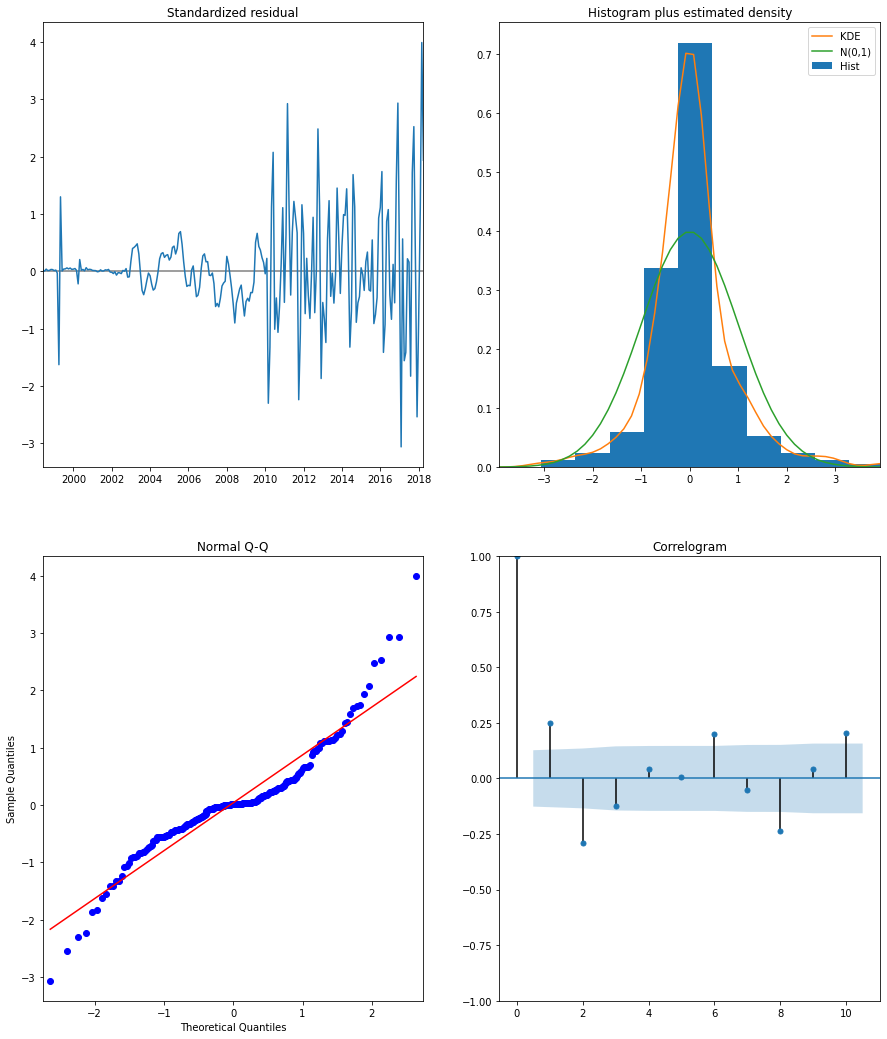

In [75]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11226, steps=36)

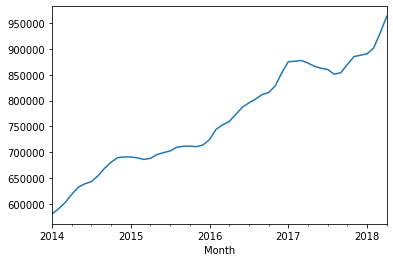

In [76]:
test_brk[11226].plot()

In [77]:
zip_11226 = zip_df[11226][:'2014']
zip_11226.describe()

count       225.000000
mean     401308.888889
std      160603.548348
min      162000.000000
25%      241000.000000
50%      451600.000000
75%      538600.000000
max      690900.000000
Name: 11226, dtype: float64

In [78]:
zip_11226_after = zip_df[11226]['2015':]
zip_11226_after.describe()

count        40.000000
mean     799572.500000
std       81511.550188
min      686100.000000
25%      711825.000000
50%      807150.000000
75%      870650.000000
max      963200.000000
Name: 11226, dtype: float64

   zipcode       roi  roi_lower  roi_upper
0    11226  0.457944   0.052723   0.863166




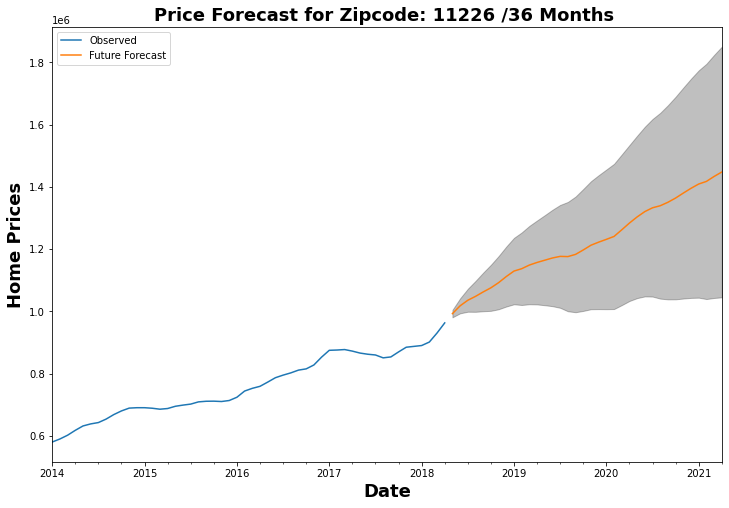

In [79]:
#	11210	(0, 1, 1)	(1, 1, 1, 12)
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[current_zip], figsize=(12,8))
forecast_visual_zip

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# mse = mean_squared_error(test_brk[11226], future_forecast)
# rmse = sqrt(mse)
# print(rmse)

### **Zipcode: 11233**

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8164      0.040     20.631      0.000       0.739       0.894
ar.S.L12      -0.7999      0.069    -11.571      0.000      -0.935      -0.664
ar.S.L24      -0.2318      0.089     -2.609      0.009      -0.406      -0.058
sigma2      1.724e+07      1e-09   1.72e+16      0.000    1.72e+07    1.72e+07


MODEL DIAGNOSTICS


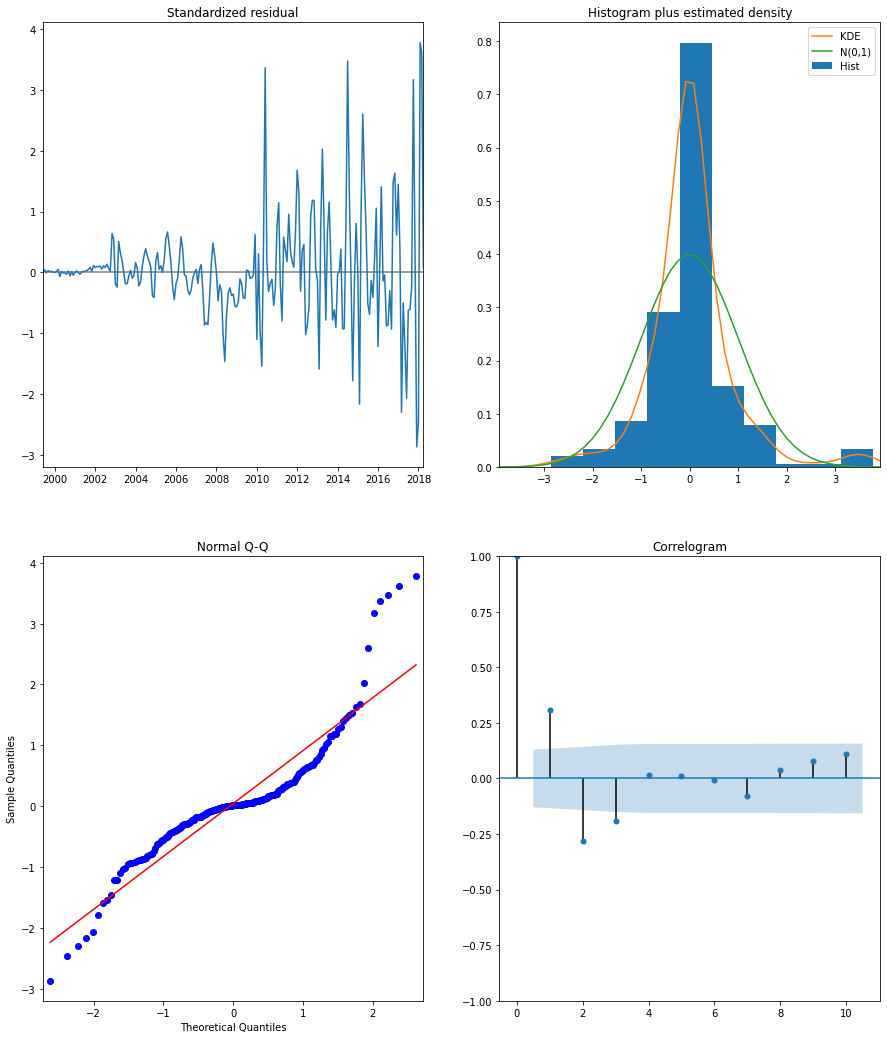

In [81]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11233,steps=36)

In [82]:
test_brk[11233].describe()

count        52.000000
mean     648321.153846
std      128326.946625
min      444700.000000
25%      525800.000000
50%      659000.000000
75%      779125.000000
max      852300.000000
Name: 11233, dtype: float64

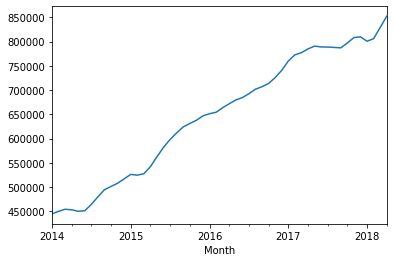

In [83]:
test_brk[11233].plot()

    zipcode       roi  roi_lower  roi_upper
11    11233  0.425923   0.062776    0.78907




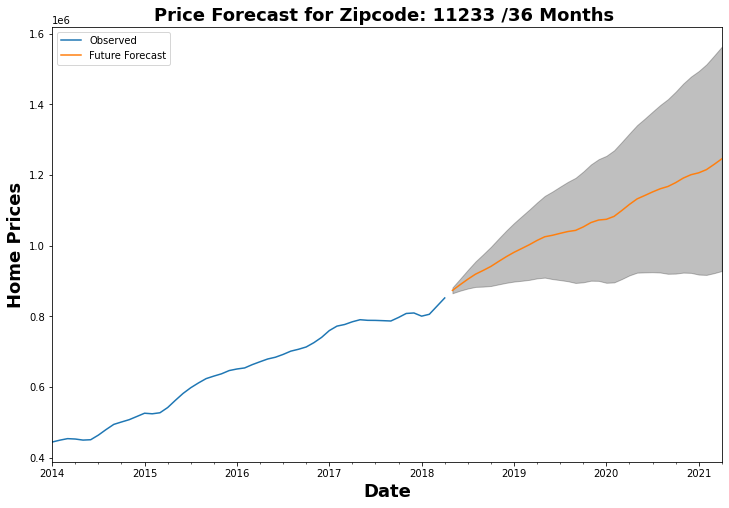

In [84]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[current_zip], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11218**

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8598      0.043     19.904      0.000       0.775       0.944
ar.S.L12      -0.6398      0.081     -7.909      0.000      -0.798      -0.481
ma.S.L12      -0.1267      0.041     -3.067      0.002      -0.208      -0.046
sigma2       4.34e+07   4.27e-10   1.02e+17      0.000    4.34e+07    4.34e+07


MODEL DIAGNOSTICS


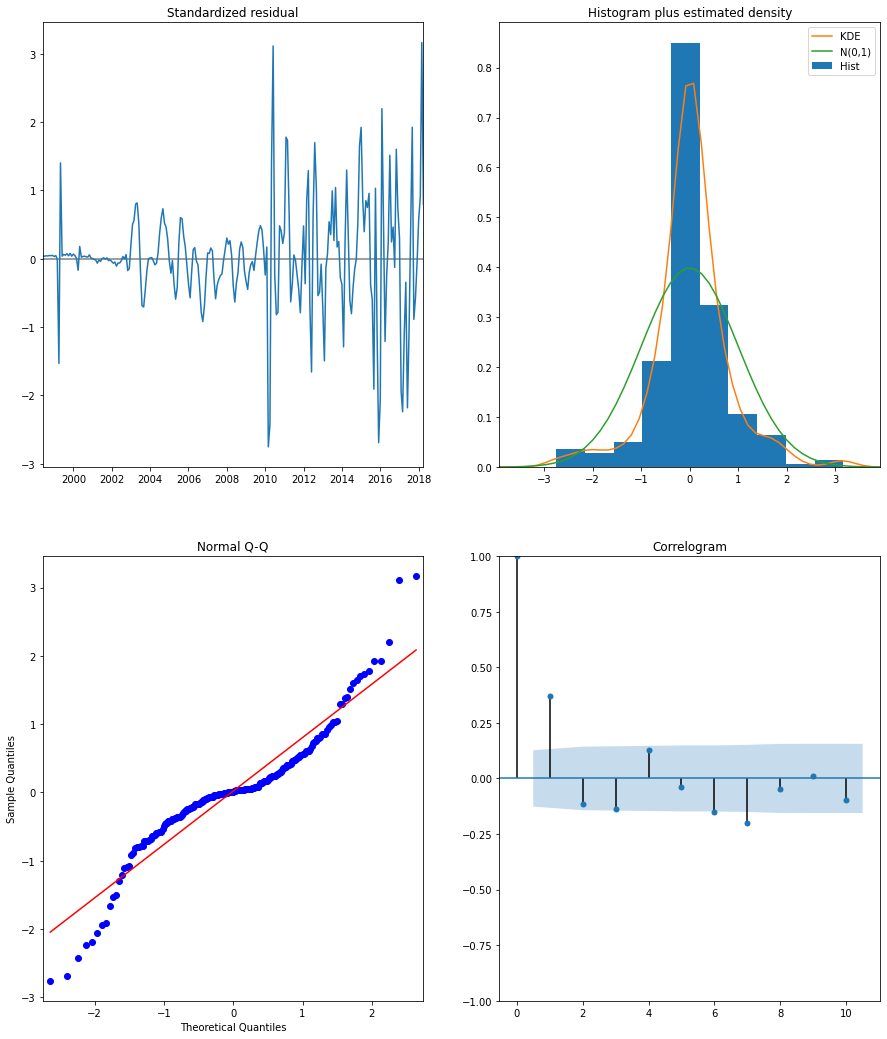

In [85]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11218,steps=36)

In [86]:
test_brk[11218].describe().round(3)

count         52.000
mean     1040128.846
std       154286.185
min       787900.000
25%       881975.000
50%      1074650.000
75%      1188750.000
max      1220900.000
Name: 11218, dtype: float64

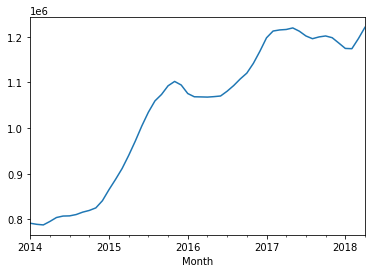

In [87]:
test_brk[11218].plot()

    zipcode       roi  roi_lower  roi_upper
13    11218  0.378893  -0.144644   0.902429




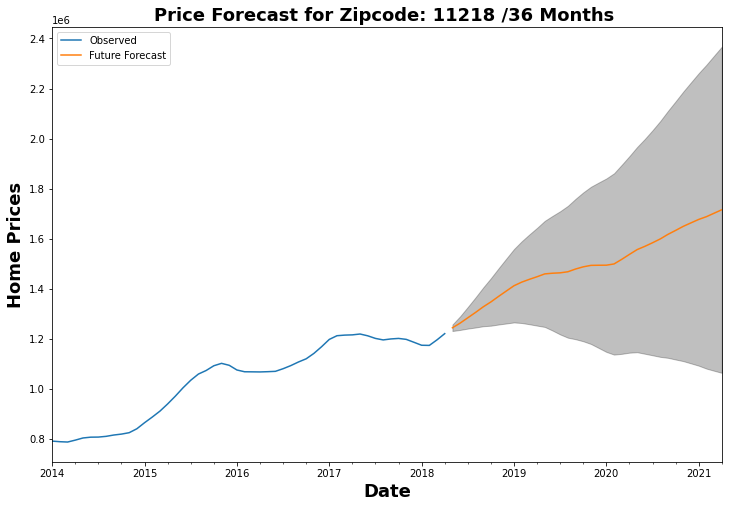

In [88]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[current_zip], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11230**

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7937      0.048     16.525      0.000       0.700       0.888
ma.L1          0.5581      0.058      9.620      0.000       0.444       0.672
ma.S.L12      -0.6262      0.078     -8.023      0.000      -0.779      -0.473
ma.S.L24       0.1562      0.055      2.865      0.004       0.049       0.263
sigma2      8.791e+06   6.29e+05     13.977      0.000    7.56e+06       1e+07


MODEL DIAGNOSTICS


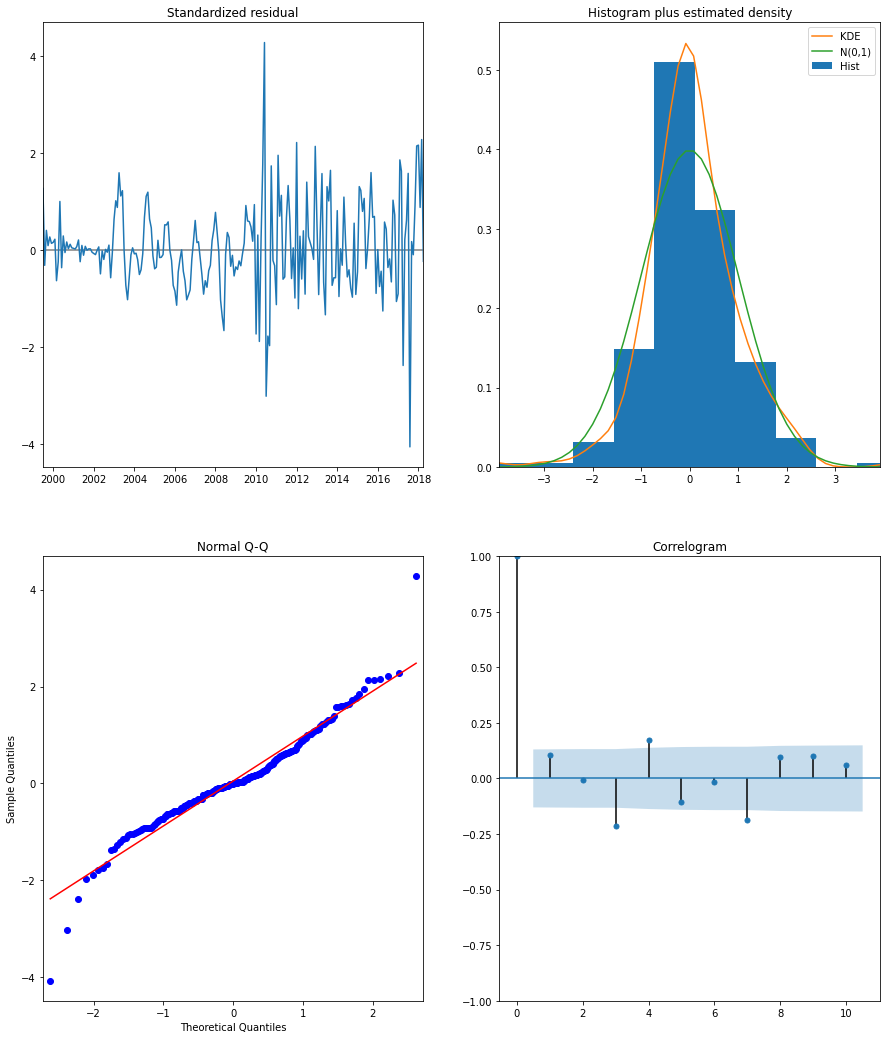

In [89]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11230,steps=36)

In [90]:
test_brk[11230].describe().round(3)

count         52.000
mean      961457.692
std       108811.199
min       819000.000
25%       840225.000
50%       977950.000
75%      1045200.000
max      1195400.000
Name: 11230, dtype: float64

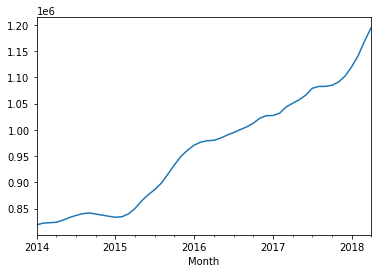

In [91]:
test_brk[current_zip].plot()

   zipcode       roi  roi_lower  roi_upper
2    11230  0.378108   0.098586   0.657631




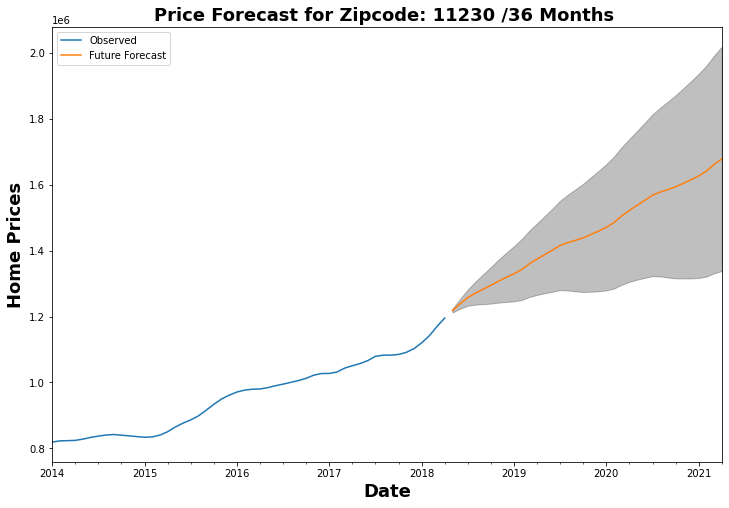

In [92]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[current_zip], figsize=(12,8))
forecast_visual_zip

### **Zipcode: 11212**

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7565      0.064     27.390      0.000       1.631       1.882
ar.L2         -1.2216      0.107    -11.426      0.000      -1.431      -1.012
ar.L3          0.3915      0.056      7.001      0.000       0.282       0.501
ar.S.L12      -0.7358      0.062    -11.954      0.000      -0.856      -0.615
ar.S.L24      -0.4012      0.054     -7.453      0.000      -0.507      -0.296
sigma2      9.655e+05   6.64e+04     14.540      0.000    8.35e+05     1.1e+06


MODEL DIAGNOSTICS


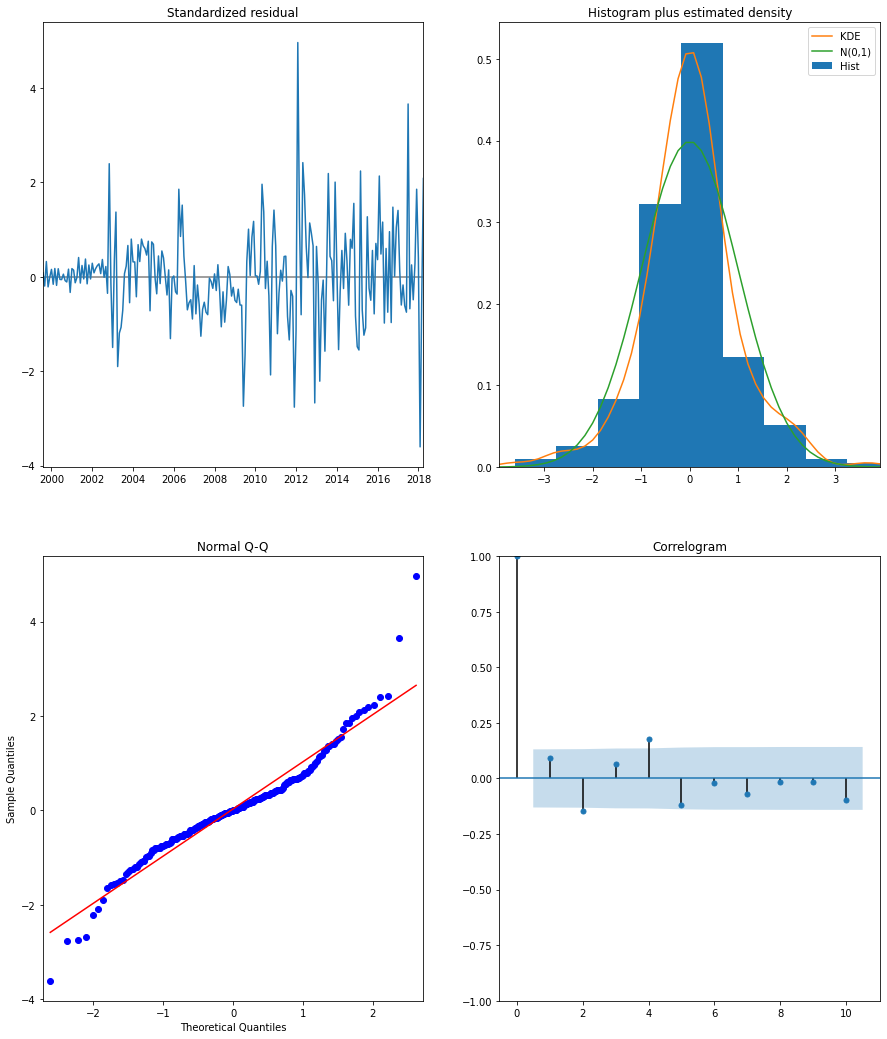

In [93]:
prediction, predict_conf, current_zip =  forecast_function(output_df, current_zip=11212,steps=36)

In [94]:
test_brk[11212].describe().round(3)

count        52.000
mean     332288.462
std       45371.390
min      285200.000
25%      298175.000
50%      308900.000
75%      367950.000
max      428400.000
Name: 11212, dtype: float64

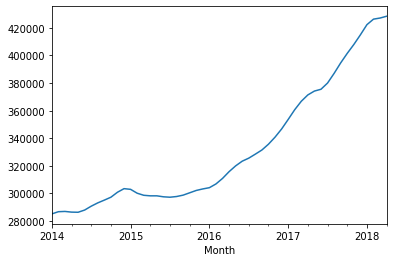

In [95]:
test_brk[current_zip].plot()

   zipcode       roi  roi_lower  roi_upper
4    11212  0.371624  -0.027713    0.77096




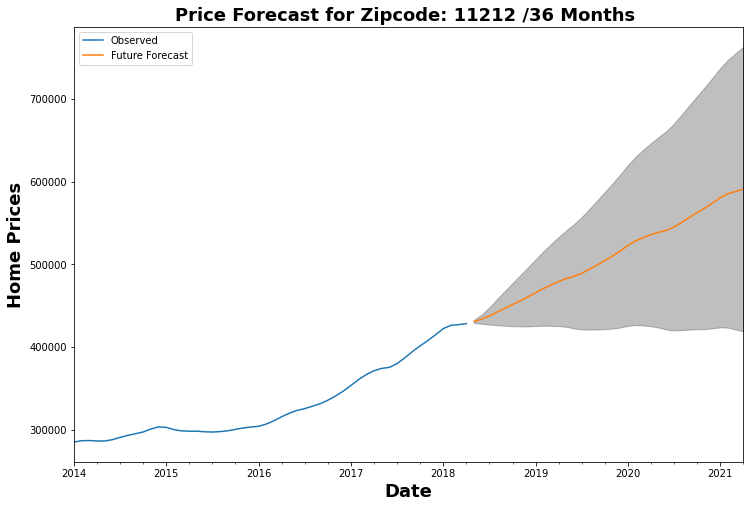

In [96]:
forecast_visual_zip = forecast_visual(prediction,predict_conf,test_brk[current_zip], figsize=(12,8))
forecast_visual_zip

## ***Stationarity***

### **Zipcode: 11226**

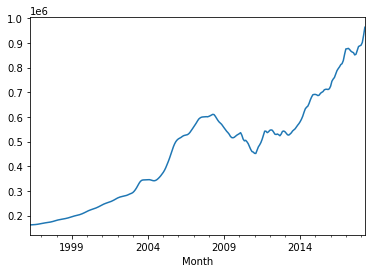

In [97]:
zip_df[11226].plot()

In [98]:
def test_stationarity_1(timeseries, window):
    
    #Defining rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='upper left')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
    plt.show()
    

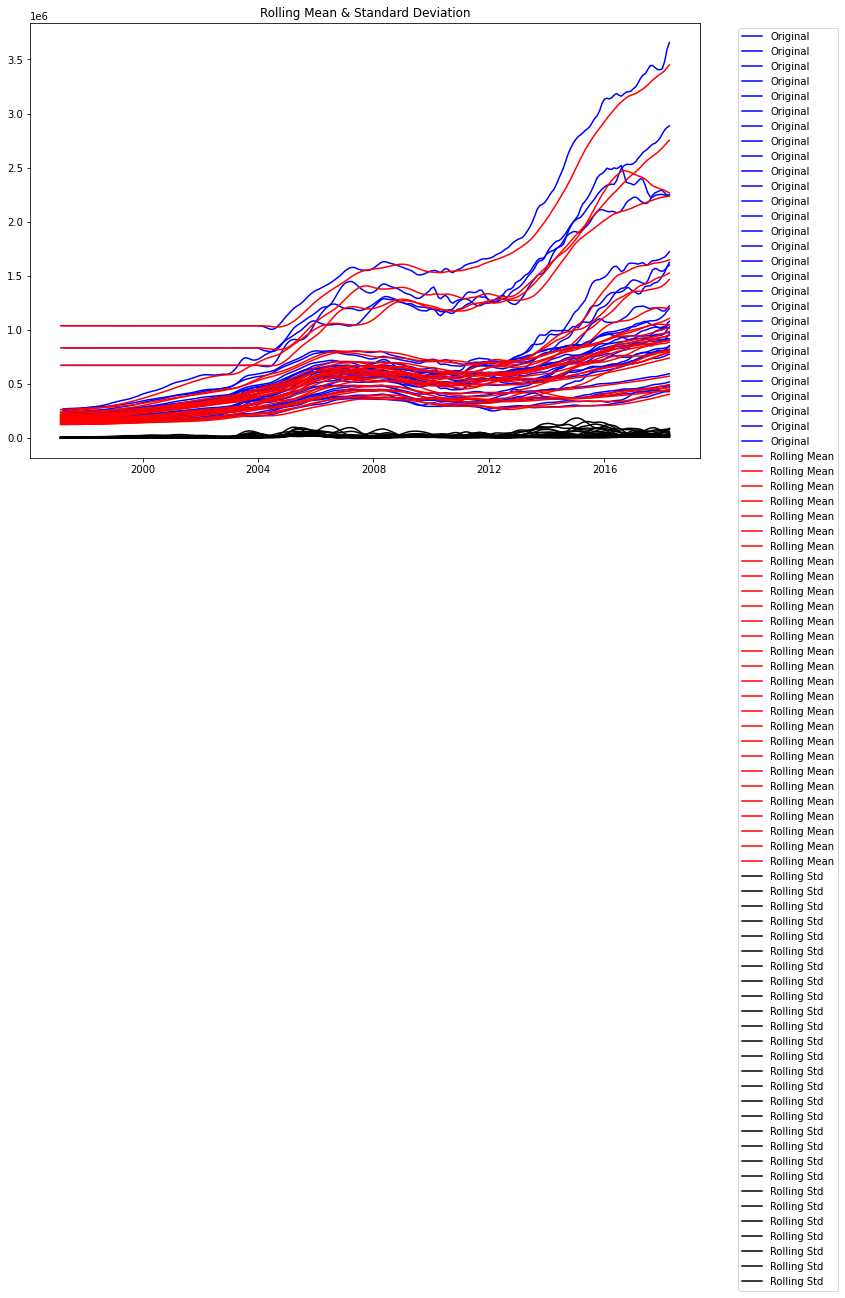

In [99]:
test_stationarity_1(zip_df,12)

In [100]:
#Not mine

def dickey_fuller_test_ind_zip(zip_code):
    dftest = adfuller(zip_code)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dftest)

    print ('Results of Dickey-Fuller Test:')

    return dfoutput

In [101]:
new_dic = {}
for col in zip_df.columns:
  zip_test = dickey_fuller_test_ind_zip(zip_df[col])
  new_dic[col] = zip_test

(0.6254102589740158, 0.9882254867110694, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 4684.550681605726)
Results of Dickey-Fuller Test:
(-0.8284459621478661, 0.8106231633355563, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4266.968811034178)
Results of Dickey-Fuller Test:
(0.22360376648978553, 0.973554814904793, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 4500.304053483356)
Results of Dickey-Fuller Test:
(-1.1262840476774874, 0.7044771402246071, 16, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, 4532.017480354275)
Results of Dickey-Fuller Test:
(-0.8616429826418738, 0.8003414457926941, 15, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, 3989.3219246723397)
Results of Dickey-Fuller Test:
(-0.002947770640627667, 0.9582876275232706, 13, 251, {'1%': -3.456674451455301

In [102]:
new_dic[11226]

Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64

In [103]:

def dickey_fuller_test_zipcodes(df):
    for col in df.columns:
        dftest = adfuller(df[col])
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print ('Results of Dickey-Fuller Test:')
        
        print(dfoutput) 
        #print(dftest)
        print ('\n')         

In [104]:
dickey_fuller_test_zipcodes(zip_df)

Results of Dickey-Fuller Test:
Test Statistic                   0.625410
p-value                          0.988225
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -0.828446
p-value                          0.810623
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                   0.223604
p-value                          0.973555
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -

In [105]:
X_1 = zip_df.copy()

In [106]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results         0.62541  ...               False

[1 rows x 5 columns]

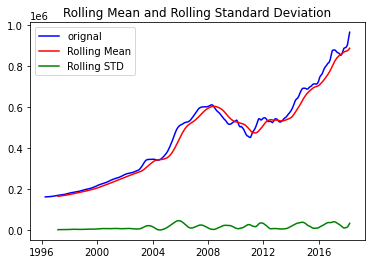

In [107]:
stationary_test(zip_df[11226])

###  Zipcode:  11238

In [108]:
#brooklyn_zips[11226]

In [109]:
#stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.6254102589740158
p-value: 0.9882254867110694
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results         0.62541  ...               False

[1 rows x 5 columns]

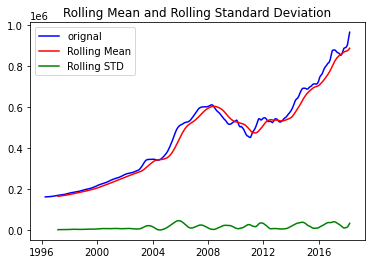

In [110]:
stationary_test(zip_df[11226])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: -0.8965122806314395
p-value: 0.7891188037192421
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results       -0.896512  ...               False

[1 rows x 5 columns]

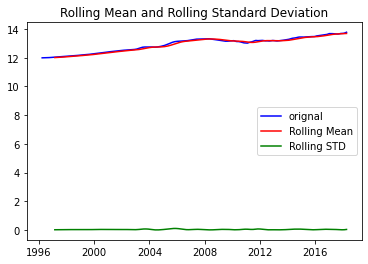

In [111]:
## Log Transform
ts3 = np.log(zip_df[11226])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -2.0776022749420107
p-value: 0.2536156786996234
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results       -2.077602  ...               False

[1 rows x 5 columns]

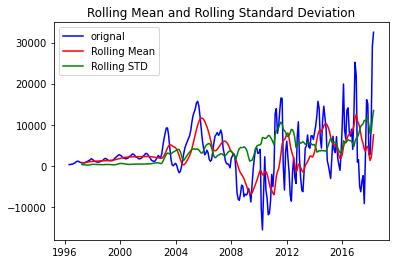

In [112]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11226].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.6919221784675216
p-value: 0.43527914575985843
Critical Values:
	1% : -3.457215237265747
	5% : -2.873361841566324
	10% : -2.5730700760129555


Test Statistic  ...  Stationary Results
AD Fuller Results       -1.691922  ...               False

[1 rows x 5 columns]

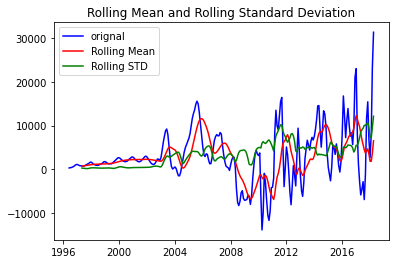

In [113]:
## Subtract Rolling mean
ts2 = (zip_df[11226] - zip_df[11226].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.386161098795962
p-value: 0.5888923863309314
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results       -1.386161  ...               False

[1 rows x 5 columns]

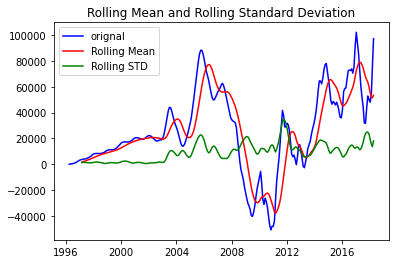

In [114]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11226] - zip_df[11226].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

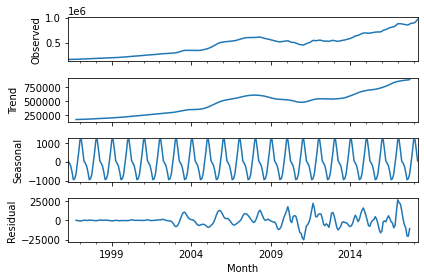

In [115]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11226])#,model='mul')
decomp.plot();

ADF statistic: -861210761297677.1
p-value: 0.0
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


Test Statistic  ...  Stationary Results
AD Fuller Results   -8.612108e+14  ...                True

[1 rows x 5 columns]

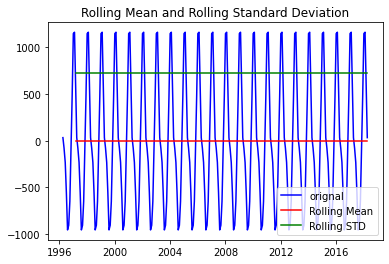

In [116]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 0.70406044441254
p-value: 0.9899185553239883
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


Test Statistic  ...  Stationary Results
AD Fuller Results         0.70406  ...               False

[1 rows x 5 columns]

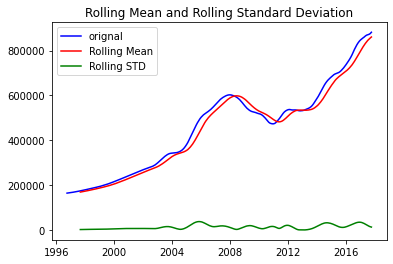

In [117]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -4.680890205249196
p-value: 9.139086370903546e-05
Critical Values:
	1% : -3.4583663275730476
	5% : -2.8738660999177132
	10% : -2.5733390785693766


Test Statistic  ...  Stationary Results
AD Fuller Results        -4.68089  ...                True

[1 rows x 5 columns]

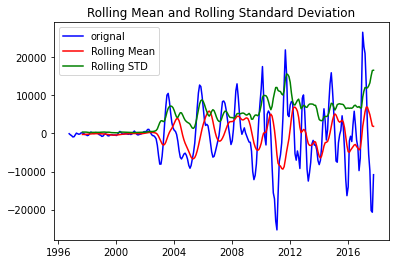

In [118]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [119]:
decomp.resid.dropna()

Month
1996-10-01      -66.765873
1996-11-01     -359.478716
1996-12-01     -561.859668
1997-01-01     -915.827922
1997-02-01     -855.113636
                  ...     
2017-06-01    -5596.978716
2017-07-01    -9750.550144
2017-08-01   -20252.534271
2017-09-01   -20681.700938
2017-10-01   -10825.099206
Freq: MS, Name: 11226, Length: 253, dtype: float64

## **RNN**

In [120]:
df_rnn = zip_df[[11238]]

In [121]:
df_rnn.head()

11238
Month               
1996-04-01  671200.0
1996-05-01  671200.0
1996-06-01  671200.0
1996-07-01  671200.0
1996-08-01  671200.0

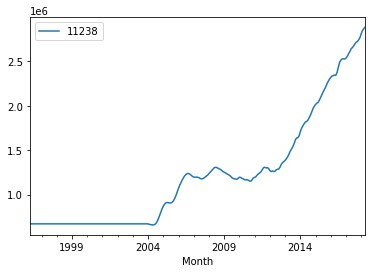

In [122]:
df_rnn.plot()

In [123]:
len(df_rnn)

265

In [124]:
265-12

253

In [125]:
"""
x_train= x_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
"""
train = df_rnn.iloc[:253]
test = df_rnn.iloc[253:]
#test = test.reshape(1, -1)
#train= train.reshape(-1, 1)

In [126]:
test

11238
Month                
2017-05-01  2639900.0
2017-06-01  2655700.0
2017-07-01  2673300.0
2017-08-01  2696700.0
2017-09-01  2716500.0
2017-10-01  2724000.0
2017-11-01  2744300.0
2017-12-01  2768900.0
2018-01-01  2810700.0
2018-02-01  2848100.0
2018-03-01  2869600.0
2018-04-01  2885300.0

In [127]:
len(test)

12

In [128]:
train.shape

(253, 1)

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [131]:
scaled_train

array([[6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],
       [6.15006150e-03],


In [132]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [133]:
n_input = 2
n_features = 1 #smaller batch sizes lead to better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [134]:
scaled_train[:5]

array([[0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006],
       [0.00615006]])

In [135]:
len(scaled_train)

253

In [136]:
"""

253 - n_input(2)

"""
len(generator)

251

In [137]:
#create model and fit it to the generator object
from keras.models import Sequential
from keras.layers import Dense  #for final output later
from keras.layers import LSTM #long short term memory

In [138]:
n_input = 12 #look at full year of data or 12 months before predicting 13th month
n_features = 1 #smaller batch sizes lead to better training
               #how many columns you have. WE have 1 column which is time stamp for y

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [139]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
#need to aggregate all the neurons to sngle prediciton
model.add(Dense(1)) #added single dense neuron which will directly output our prediction
model.compile(optimizer='adam', loss='mse')

In [140]:
"""
may want to play around w/number of neurons on LSTM layer
"""
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [141]:
"""
fit tou our training generator
more epochs you use hte longer it's going to take to train
1 epoch is a single entire run through of training data

We get significant reduciton over 1st couple of epochs then around 15 start seeing convergence

"""
model.fit_generator(train_generator, epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
241/241 [==============================] - 5s 22ms/step - loss: 0.0061
Epoch 2/25
241/241 [==============================] - 5s 22ms/step - loss: 0.0011
Epoch 3/25
241/241 [==============================] - 5s 21ms/step - loss: 7.4513e-04
Epoch 4/25
241/241 [==============================] - 5s 21ms/step - loss: 9.7093e-04
Epoch 5/25
241/241 [==============================] - 5s 22ms/step - loss: 9.1444e-04
Epoch 6/25
241/241 [==============================] - 5s 21ms/step - loss: 8.8161e-04
Epoch 7/25
241/241 [==============================] - 5s 22ms/step - loss: 0.0020
Epoch 8/25
241/241 [==============================] - 5s 22ms/step - loss: 6.4988e-04
Epoch 9/25
241/241 [==============================] - 5s 22ms/step - loss: 5.2975e-04
Epoch 10/25
241/241 [==============================] - 5s 21ms/step - loss: 3.9236e-04
Epoch 11/25
241/241 [==============================] - 5s 21ms/step - loss:

In [142]:
model.history.history.keys()

dict_keys(['loss'])

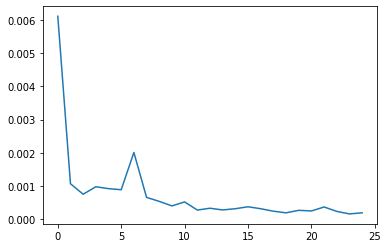

In [143]:
plt.plot(range(len(model.history.history['loss'])),model.history.history['loss']);

In [144]:
"""
evalute on the test data
create an evlauation batch
our network trains 1 step ahead

our network is 12 network steps 
    then predict step 13
    
need last 12 points of training data inorder to predict pt. 1 of test data 

these are last 12 points of training set
"""
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.86341738],
       [0.88104756],
       [0.91149036],
       [0.93890939],
       [0.95126076],
       [0.95807708],
       [0.95879459],
       [0.95756458],
       [0.96258713],
       [0.97263223],
       [0.98708487],
       [1.        ]])

In [145]:
"""
it now has 3 brackets at the top
"""
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))
first_eval_batch

array([[[0.86341738],
        [0.88104756],
        [0.91149036],
        [0.93890939],
        [0.95126076],
        [0.95807708],
        [0.95879459],
        [0.95756458],
        [0.96258713],
        [0.97263223],
        [0.98708487],
        [1.        ]]])

In [146]:
"""
call model on first_eval_batch
gives array prediciton
means given these 12 points of training data it predicts taht below should be 1st point of test data set
"""
model.predict(first_eval_batch)

array([[1.0246336]], dtype=float32)

In [147]:
scaled_test

array([[1.0151189 ],
       [1.02321648],
       [1.03223657],
       [1.04422919],
       [1.05437679],
       [1.05822058],
       [1.06862444],
       [1.08123206],
       [1.10265478],
       [1.12182247],
       [1.13284133],
       [1.14088766]])

In [148]:
"""
not just predict 1st point in test set but the entire test set
how to forecast into the future
Forecast using RNN model
"""
#hold predicitons
test_predictions = []
#last n_input points from training set
first_eval_batch = scaled_train[-n_input:] 
#reshape to format of RNN wants, (same format as Timeseriesgenerator 
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#hoe far into the futrue will I forecast: length of test set
for i in range(len(test)):
    #1time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0] #0 is for formatting 
    test_predictions.append(current_pred)
    
    #update current batch to include prediciton
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [149]:
test_predictions

[array([1.0246336], dtype=float32),
 array([1.0424883], dtype=float32),
 array([1.0613439], dtype=float32),
 array([1.0806745], dtype=float32),
 array([1.100172], dtype=float32),
 array([1.1196685], dtype=float32),
 array([1.1391215], dtype=float32),
 array([1.1584947], dtype=float32),
 array([1.1777699], dtype=float32),
 array([1.1969194], dtype=float32),
 array([1.2159245], dtype=float32),
 array([1.2347448], dtype=float32)]

In [150]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[2658465.17009735],
       [2693303.24230194],
       [2730094.23389435],
       [2767812.14113235],
       [2805855.69000244],
       [2843897.14546204],
       [2881853.93409729],
       [2919654.87995148],
       [2957264.6276474 ],
       [2994629.2137146 ],
       [3031711.88716888],
       [3068434.02881622]])

In [151]:
test['Predictions'] = true_predictions

In [152]:
test

11238   Predictions
Month                              
2017-05-01  2639900.0  2.658465e+06
2017-06-01  2655700.0  2.693303e+06
2017-07-01  2673300.0  2.730094e+06
2017-08-01  2696700.0  2.767812e+06
2017-09-01  2716500.0  2.805856e+06
2017-10-01  2724000.0  2.843897e+06
2017-11-01  2744300.0  2.881854e+06
2017-12-01  2768900.0  2.919655e+06
2018-01-01  2810700.0  2.957265e+06
2018-02-01  2848100.0  2.994629e+06
2018-03-01  2869600.0  3.031712e+06
2018-04-01  2885300.0  3.068434e+06

### **RNN Plot / Sales v Predicted Values**

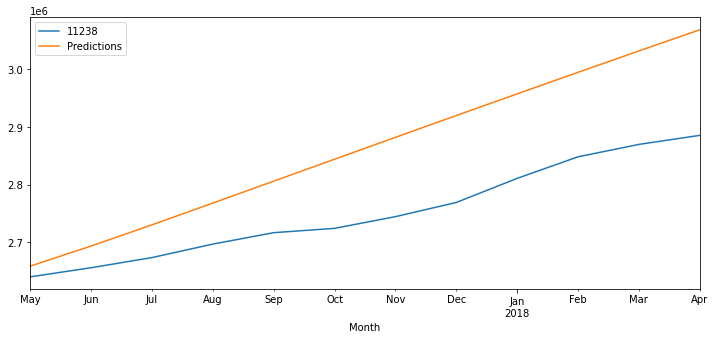

In [153]:
"""
sales v predicted values
"""
test.plot(figsize=(12,5));